In [1]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit
from scipy.stats import linregress
from scipy.stats import nbinom
import warnings
warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from numba import njit
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


In [107]:
from numba import njit
@njit
def energyscore_multipletargets(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum(((X[i]-y)/y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum(((X[i]-X[j])/y)**2))/(2*N**2)
    return ES


In [108]:
# toy example
hosp = np.array([np.array([90, 96]), np.array([105, 110])])
case = np.array([np.array([950, 1001]), np.array([1100, 1030])])
death = np.array([np.array([5,6]), np.array([12,9])])

X1 = np.array([hosp[0], case[0], death[0]])
X2 = np.array([hosp[1], case[1], death[1]])
A = np.array([X1, X2])

obsh = np.array([100, 103])
obsc = np.array([1000, 999])
obsd = np.array([10, 11])

obs = np.array([obsh, obsc, obsd])
#X = np.array([hosp, case, death])

In [109]:
energyscore_multipletargets(A, obs)

0.2968622335968441

In [93]:
.5*(np.sqrt(((90-100)/100)**2+(((96-103)/103)**2)+(((950-1000)/1000)**2)+(((1001-999)/999)**2)+\
   (((5-10)/10)**2)+(((6-11)/11)**2)) + np.sqrt(((105-100)/100)**2+(((110-103)/103)**2)+(((1100-1000)/1000)**2)+\
    (((1030-999)/999)**2)+ (((12-10)/10)**2)+(((9-11)/11)**2)) ) - .25*(np.sqrt(((90-105)/100)**2 + \
    ((96-110)/103)**2)+ ((950-1100)/1000)**2+ ((1001-1030)/999)**2+ ((5-12)/10)**2+ ((6-9)/11)**2)

0.2975520430877922

# Flu SMH

In [5]:
def pull_flu_scenario_modeling_hub_predictions(model,dates):
    """pull_scenario_modeling_hub_predictions. Load predictions of the model saved by the scenario modeling
    hub.

    Parameters  
    ----------
    model : str
        Model name on thhe
    dates : list or string
        List of potential dates in the iso format, e.g., 'yyyy-mm-dd', for the submission.
    """
    predictions = None
    if isinstance(dates,str):
        dates = [dates]
    for date in dates:
        url = f"https://raw.githubusercontent.com/midas-network/flu-scenario-modeling-hub/master/data-processed/{model}/{date}-{model}"
        for ext in [".gz.parquet", ".parquet"]:
                try:
                    predictions = pd.read_parquet(url+ext)
                    
                except:
                    pass

    if predictions is None:
        print(f"Data for model {model} and date {dates} unavailable")
    return predictions


# Multitarget energy score for MOBS model

In [6]:
# use Flu SMH data and shuffle trajectory matrices for hospitalizations in all states and calculate energy score
# for different matrix formulations

In [390]:
modelmap = {'MOBS_NEU-GLEAM_FLU':'Model A', 'NIH-Flu_TS': 'Model B','NotreDame-FRED':'Model C',
            'PSI-M2':'Model D', 'USC-SIkJalpha':'Model E', 'UT-ImmunoSEIRS':'Model F'}

In [391]:
# include all models, even those only submitting for one location
#modelsall = ['MOBS_NEU-GLEAM_FLU']
modelsall = ['MOBS_NEU-GLEAM_FLU', 'NotreDame-FRED', 'USC-SIkJalpha', 'UT-ImmunoSEIRS',
                  'NIH-Flu_TS', 'PSI-M2']

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(hosp.date.max())


predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    df = pull_flu_scenario_modeling_hub_predictions(model,'2023-09-03')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    df['Model'] = model
    df['trajectory_id'] = df['output_type_id'] + 100*i
    
    numweeks = list(df.horizon.unique())
    start_date = list(df.origin_date.unique())[0]
    date_1 = pd.to_datetime(start_date)

    alldates = []
    for wk in numweeks:
        if wk==1:
            d = date_1 + timedelta(days=6*int(wk))
        else:
            d = pd.to_datetime("2023-09-02") + timedelta(weeks=int(wk))

        alldates.append(d)

    dfdates = pd.DataFrame({'horizon':numweeks, 'target_end_date':alldates}) # add date of prediction to dataframe
    df = df.merge(dfdates, how='inner', on='horizon')

    predictionsall = pd.concat([predictionsall, df])
    i += 1
    
    
# filter by dates with data
predictionsall = predictionsall[predictionsall.target_end_date <= max_date]    
     
    

In [435]:
dfmobs = predictionsall[(predictionsall.Model=='MOBS_NEU-GLEAM_FLU') & (predictionsall.target=='inc hosp')]

In [436]:
#hospitalizations
target = 'hospitalization'
incidence=True
hosp = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target}.pq")
hosp['date'] = pd.to_datetime(hosp['date'])
hosp = hosp[(hosp.date>pd.to_datetime('2023-11-18'))].sort_values(by=['date']).reset_index().drop(columns=\
                                                                        ['Unnamed: 0', 'index','weekly_rate'])

hosp = hosp[(hosp.location != '72') &(hosp.location!='66')]
#h = np.array(hosp['value'])
#obs = np.array([h,d])

In [394]:
obs = np.array([np.array(hosp[hosp.location == i].value) for \
                     i in hosp.location.unique()])
locations = list(hosp.location.unique())

In [160]:

energyscores_locations = pd.DataFrame()
for it in range(100):
    for model in ['MOBS_NEU-GLEAM_FLU']:
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:

            loc_array ={}
            j=0
            for loc in locations:
                if loc in ['72', '66']:
                    continue
                predictionshosp = dfmobs[(dfmobs.scenario_id == scenario + '-2023-08-14') & \
                                            (dfmobs.target_end_date <= hosp.date.max()) & \
                                            (dfmobs.target_end_date >= hosp.date.min())&\
                                            (dfmobs.Model == model) &\
                                            (dfmobs.location==loc)]

                newid = random.sample(list(predictionshosp['trajectory_id']), 
                                      k=len(list(predictionshosp['trajectory_id'])))
                predictionshosp['new_id'] = newid

                Xhosp = np.array([np.array(predictionshosp[predictionshosp.new_id == i].value) for \
                         i in predictionshosp.new_id.unique()])
                
                loc_array[loc] = Xhosp
                
                j+=1
                
            A = []
            for i in range(len(Xhosp)):
                B = []
                for loc in locations:
                    if loc in ['72', '66']:
                        continue
                    B.append(loc_array[loc][i])
                B = np.array(B)
                A.append(B)

            A = np.array(A)



            ES = energyscore_multipletargets(A,obs)


            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':'US',  
                                 'energyscore': ES, 'it':it}, index=[0])

            energyscores_locations = pd.concat([energyscores_locations, newrow])

energyscores_locations = energyscores_locations.reset_index().drop(columns=['index'])  

In [372]:
energyscores_locations.to_csv('../fludat/multitarget_loc_MOBS.csv')

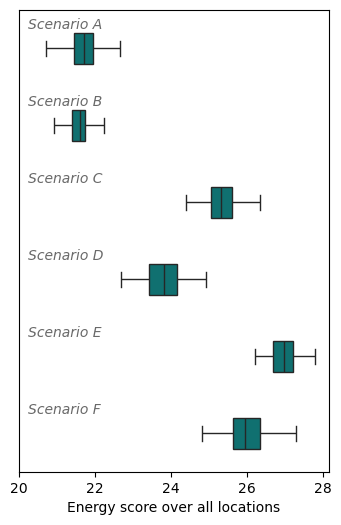

In [333]:
# plot multi-target energy score across all locations just for MOBS model
fig, ax = plt.subplots(1,1,figsize=(4,6), sharex=True)

my_order = list(energyscores_locations.Label.unique())
sns.boxplot(x='energyscore', y='Label', data=energyscores_locations, width=.4, showfliers=False, color='teal')
plt.ylabel('')
plt.yticks([])
plt.xlabel('Energy score over all locations')

a=0
for mod in list(my_order):
    plt.text(20.25,a-.25, mod, fontsize=10, style='italic', color='dimgray')
    a+=1

plt.xticks([20, 22, 24, 26, 28])

plt.savefig('../figs/mulitargets_locations_MOBS.pdf')

21.70863350193692
21.609592047440906
25.32603107277785
23.813863628749694
26.973543752561504
25.945745086242425


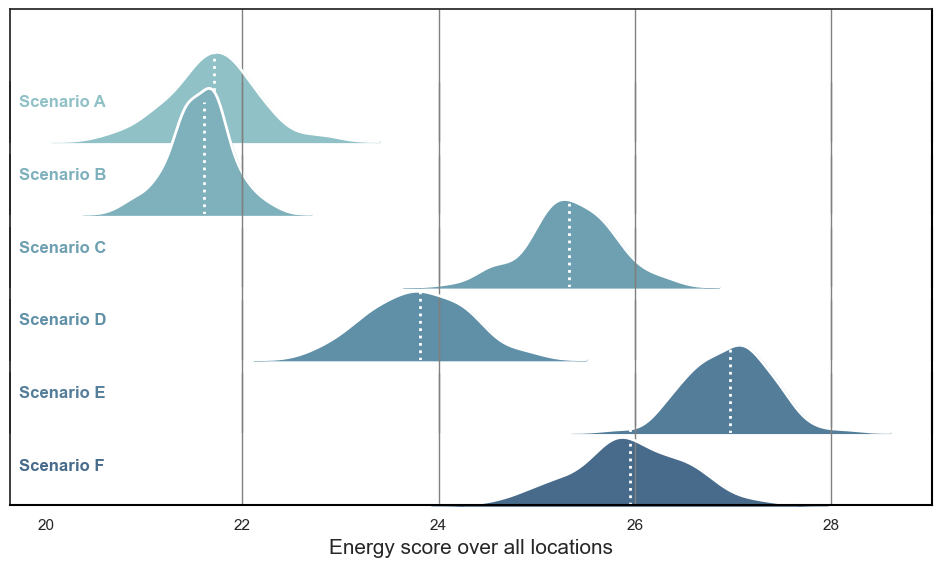

In [82]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

energyscores_locations = pd.read_csv('../fludat/multitarget_loc_MOBS.csv')
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(energyscores_locations, row="Label", hue="Label", aspect=10, height=1, palette=pal)


for ax in g.axes.flat:
    
    # Plot a vertical line at x=20 for each subplot
   # ax.axvline(20,ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
    ax.axvline(22,ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
    ax.axvline(24,ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
    ax.axvline(26, ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
    ax.axvline(28, ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)




# Draw the densities in a few steps
g.map(sns.kdeplot, "energyscore",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "energyscore", clip_on=False, color="w", lw=2, bw_adjust=1)

# passing color=None to refline() uses the hue mapping
#g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(.01, .3, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "energyscore")

# Define a function to plot the median
def plot_median(data, color, label):
    median = np.median(data['energyscore'])
    plt.axvline(median,ymin=0, ymax=.85, color='white', linestyle=':', linewidth=2)
    print(median)
    

# Apply the function to plot the median
g.map_dataframe(plot_median)


# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xticks=[20,22,24,26,28])
g.set_xticklabels([20, 22, 24, 26, 28])
#g.despine(bottom=True, left=True)


g.despine(bottom=True, left=False)
# Add a box around the full figure
#g.fig.patch.set_edgecolor('black')  # Set the edge color to black
#g.fig.patch.set_linewidth(2)        # Set the line width of the box

i=0

#g.set(xlim=[19, 29])

for ax in g.axes.flat:
    if i==0:
        ax.spines['top'].set_visible(True)
    elif i==1:
        ax.set_xticks([20, 22, 24, 26, 28])  # Set custom tick locations
        ax.set_xticklabels([20, 22, 24, 26, 28], fontsize=13)  # Set custom tick labels and fontsize

    ax.spines['right'].set_visible(True)
    ax.spines['right'].set_edgecolor('black')
    ax.spines['right'].set_linewidth(1.5)
    
    if i==5:
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_edgecolor('black')
        ax.spines['bottom'].set_linewidth(1.5)


    i+=1

#plt.xlim([-45, 32])
plt.xlabel('Energy score over all locations', fontsize=15)

#plt.xticks([20,22,24,26,28],fontsize=13)

#plt.xticks([20,22,24,26,28])

#g.set_xticks([20, 22, 24, 26, 28])  # Set custom tick locations
#g.set_xticklabels([20, 22, 24, 26, 28], fontsize=13)  # Set custom tick labels and fontsize
#g.set(xticks=[20,22,24,26,28])

#plt.ylabel('% infectious-detectable \n stopped '+r'from traveling, $\phi_b$', y=1.1, fontsize=12)

plt.savefig('../figs/multitarget_MOBS_kdeplot_1015.pdf')
plt.show()

0.6572844692009241
0.6542857355477214
0.7668104438334016
0.7210257022142534
0.8166931090475327
0.7855738725107568


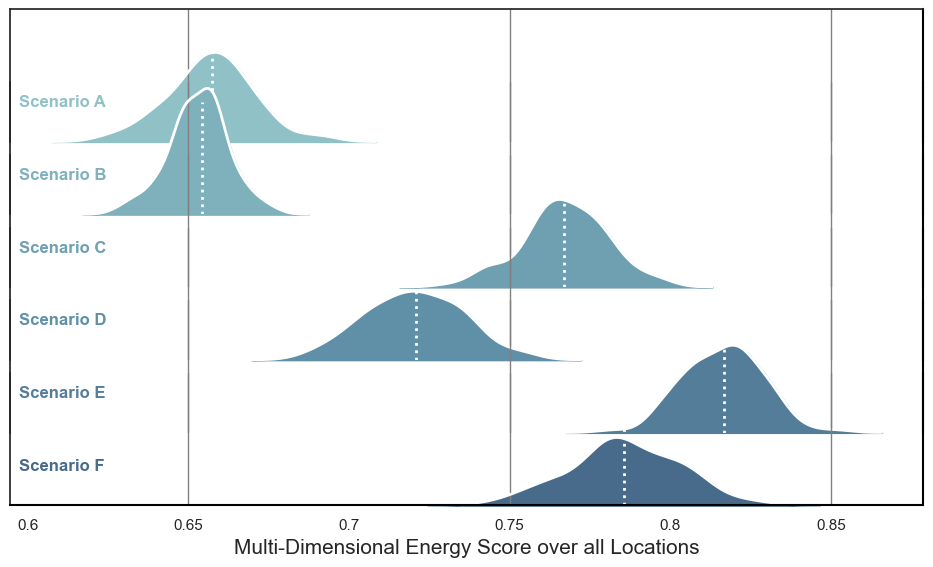

In [92]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

energyscores_locations = pd.read_csv('../fludat/multitarget_loc_MOBS.csv')
baseline_locations = pd.read_pickle('../fludat/flu-baseline_energyscore_multidim.pkl')
baseline_avg = baseline_locations.energyscore.mean()

energyscores_locations['energyscore_ratio'] = energyscores_locations['energyscore'] / baseline_avg

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(energyscores_locations, row="Label", hue="Label", aspect=10, height=1, palette=pal)


for ax in g.axes.flat:
    
    # Plot a vertical line at x=20 for each subplot
   # ax.axvline(20,ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
    ax.axvline(.65,ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
    ax.axvline(.75,ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
    ax.axvline(.85, ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
    #ax.axvline(28, ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)




# Draw the densities in a few steps
g.map(sns.kdeplot, "energyscore_ratio",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "energyscore_ratio", clip_on=False, color="w", lw=2, bw_adjust=1)

# passing color=None to refline() uses the hue mapping
#g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(.01, .3, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "energyscore")

# Define a function to plot the median
def plot_median(data, color, label):
    median = np.median(data['energyscore_ratio'])
    plt.axvline(median,ymin=0, ymax=.85, color='white', linestyle=':', linewidth=2)
    print(median)
    

# Apply the function to plot the median
g.map_dataframe(plot_median)


# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xticks=[.6,.65,.7,.75,.8,.85])
#g.set_xticklabels([20, 22, 24, 26, 28])
#g.despine(bottom=True, left=True)


g.despine(bottom=True, left=False)
# Add a box around the full figure
#g.fig.patch.set_edgecolor('black')  # Set the edge color to black
#g.fig.patch.set_linewidth(2)        # Set the line width of the box

i=0

#g.set(xlim=[19, 29])

for ax in g.axes.flat:
    if i==0:
        ax.spines['top'].set_visible(True)
    elif i==1:
        ax.set_xticks([.6,.65,.7,.75,.8,.85])  # Set custom tick locations
        ax.set_xticklabels([.6,.65,.7,.75,.8,.85], fontsize=13)  # Set custom tick labels and fontsize

    ax.spines['right'].set_visible(True)
    ax.spines['right'].set_edgecolor('black')
    ax.spines['right'].set_linewidth(1.5)
    
    if i==5:
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_edgecolor('black')
        ax.spines['bottom'].set_linewidth(1.5)


    i+=1

#plt.xlim([-45, 32])
plt.xlabel('Multi-Dimensional Energy Score over all Locations', fontsize=15)

#plt.xticks([20,22,24,26,28],fontsize=13)

#plt.xticks([20,22,24,26,28])

#g.set_xticks([.2,.4,.6,.8,1,1.2,1.4,1.6,1.8,2])  # Set custom tick locations
#g.set_xticklabels([.2,.4,.6,.8,1,1.2,1.4,1.6,1.8,2], fontsize=13)  # Set custom tick labels and fontsize
#g.set(xticks=[20,22,24,26,28])

#plt.ylabel('% infectious-detectable \n stopped '+r'from traveling, $\phi_b$', y=1.1, fontsize=12)

plt.savefig('../figs/multitarget_MOBS_kdeplot_baseline.pdf')
plt.show()

In [123]:
loc_array

{'56': array([[1.2453e+01, 4.7670e+00, 9.1600e+00, ..., 3.6770e+00, 1.0976e+01,
         1.0110e+00],
        [1.3530e+01, 6.0690e+00, 3.9467e+01, ..., 6.7660e+00, 6.2820e+00,
         1.1960e+00],
        [1.4862e+01, 1.2571e+01, 8.5000e-02, ..., 1.6540e+00, 2.8310e+00,
         4.4930e+00],
        ...,
        [4.8490e+00, 4.6310e+00, 4.7128e+01, ..., 3.4730e+00, 1.0070e+00,
         1.4260e+00],
        [3.9260e+00, 3.2101e+01, 9.1300e-01, ..., 1.1800e-01, 6.4500e-01,
         5.0700e+00],
        [3.3680e+00, 2.0304e+01, 2.2677e+01, ..., 4.9500e-01, 8.0000e-03,
         2.0000e+00]]),
 '26': array([[134.12 , 212.532,  20.655, ...,  61.212,  76.384,  21.221],
        [152.51 , 300.23 , 118.014, ...,  12.278,  45.142,  11.348],
        [ 20.273,  24.168,  27.808, ...,  58.599,  11.319,  38.536],
        ...,
        [504.21 , 110.668, 301.334, ...,  18.452,  11.704,  28.252],
        [728.718, 167.589, 154.052, ...,  28.11 ,  13.923,  15.137],
        [ 98.396,  86.054, 535.247, ...

# Energy score for multiple targets for all models

In [163]:
dfall = predictionsall[(predictionsall.target=='inc hosp')]

In [271]:
energyscores_locall = pd.DataFrame()
for it in range(100):
    print(it)
    for model in ['MOBS_NEU-GLEAM_FLU', 'NotreDame-FRED', 'USC-SIkJalpha', 'UT-ImmunoSEIRS',
                  'NIH-Flu_TS', 'PSI-M2']:
        #print(model)
        for scenario in ['D']:

            loc_array ={}
            j=0
            for loc in locations:
                if loc in ['72', '66', '69','60', '78']:
                    continue
                predictionshosp = dfall[(dfall.scenario_id == scenario + '-2023-08-14') & \
                                            (dfall.target_end_date <= hosp.date.max()) & \
                                            (dfall.target_end_date >= hosp.date.min())&\
                                            (dfall.Model == model) &\
                                            (dfall.location==loc)]
                hospfilt = hosp[hosp.location.isin(dfall[dfall.Model==model].location.unique())]
                obsnew = np.array([np.array(hospfilt[hospfilt.location == i].value) for \
                     i in hospfilt.location.unique()])
                

                newid = random.sample(list(predictionshosp['trajectory_id']), 
                                      k=len(list(predictionshosp['trajectory_id'])))
                predictionshosp['new_id'] = newid
                
                if len(predictionshosp)==0:
                    continue

                Xhosp = np.array([np.array(predictionshosp[predictionshosp.new_id == i].value) for \
                         i in predictionshosp.new_id.unique()])
                
                loc_array[loc] = Xhosp
                
                j+=1
                
            A = []
            for i in range(len(Xhosp)):
                B = []
                for loc in loc_array.keys():
                    if loc in ['72', '66']:
                        continue
                    if len(loc_array[loc]) ==0:
                        continue
                        
                    B.append(loc_array[loc][i])
                B = np.array(B)
                A.append(B)

            C = np.array(A)



            ES = energyscore_multipletargets(C,obsnew)


            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 
                                 'energyscore': ES, 'it':it}, index=[0])

            energyscores_locall = pd.concat([energyscores_locall, newrow])

energyscores_locall = energyscores_locall.reset_index().drop(columns=['index'])  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [272]:
energyscores_locall.to_pickle('../fludat/energyscore_mt_locations_scenD_101.pkl')

In [45]:
energyscores_locall = pd.read_pickle('../fludat/energyscore_mt_locations_scenD_101.pkl')

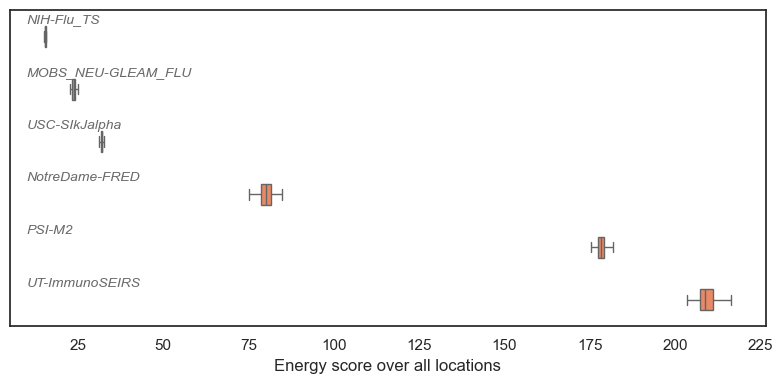

In [403]:
fig, ax = plt.subplots(1,1,figsize=(8,4), sharex=True)

#df= energyscores_locall

my_order = energyscores_locall.groupby(by=["Model"])["energyscore"].median().sort_values(ascending=True).index
ges = sns.boxplot(x='energyscore', y='Model', data=energyscores_locall, width=.4,order=my_order, 
            showfliers=False, color='coral')
plt.ylabel('')
plt.xlabel('Energy score over all locations')


ges.set(yticklabels=[])
ges.set(yticks=[])
ges.set(ylabel=None)
#ges.set(xlabel=None)
#ges.set(xticklabels=[])
#ges.set(xticks=[2.5, 5, 10, 15, 20])
#plt.xlim([0,800])

a = 0
for mod in list(my_order):
    plt.text(10,a-.25, mod, fontsize=10, style='italic', color='dimgray')
    a+=1

#plt.xscale('log')

#plt.xlim([0,100])
plt.tight_layout()
plt.show()

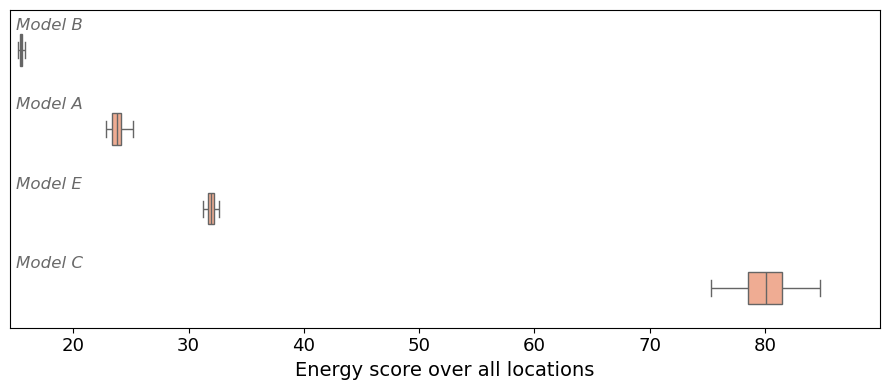

In [99]:
fig, ax = plt.subplots(1,1,figsize=(9,4), sharex=True)
mpl.rc_file_defaults()
df= energyscores_locall[(energyscores_locall.Model != 'PSI-M2') & (energyscores_locall.Model != 'UT-ImmunoSEIRS')]

my_order = df.groupby(by=["Model"])["energyscore"].median().sort_values(ascending=True).index
ges = sns.boxplot(x='energyscore', y='Model', data=df, width=.4,order=my_order, 
            showfliers=False, color='coral')
plt.ylabel('')
plt.xlabel('Energy score over all locations', fontsize=14)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .7))
    
#sns.swarmplot(x='energyscore', y='Model', data=df, order=my_order, color='coral', orient='h',size=1,alpha=.95)

ges.set(yticklabels=[])
ges.set(yticks=[])
ges.set(ylabel=None)
#ges.set(xlabel=None)

#ges.set(xticks=[20, 40, 60, 80], xticklabels=[20, 40, 60, 80])
#ges.set(xticklabels=[])
plt.xlim([10,90])

a = 0
for mod in list(my_order):
    plt.text(15,a-.25, modelmap[mod], fontsize=12, style='italic', color='dimgray')
    a+=1

#plt.xscale('log')
#plt.xticks([20, 40, 60, 80])
#plt.xticks([20, 40, 60, 80])

plt.xlim([14.5,90])
plt.xticks([20, 30,40, 50,60,70, 80], fontsize=13)
ges.set(xticks=[20, 30,40, 50,60,70, 80], xticklabels=[20, 30,40, 50,60,70, 80])
plt.tight_layout()

plt.savefig('../figs/multitarget_locations_models_1017.pdf')
plt.show()

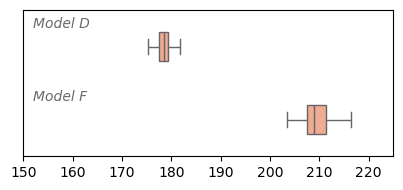

In [450]:
fig, ax = plt.subplots(1,1,figsize=(4,2), sharex=True)

df= energyscores_locall[(energyscores_locall.Model.isin(['PSI-M2', 'UT-ImmunoSEIRS'])) ]

my_order = df.groupby(by=["Model"])["energyscore"].median().sort_values(ascending=True).index
ges = sns.boxplot(x='energyscore', y='Model', data=df, width=.4,order=my_order, 
            showfliers=False, color='coral')

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .7))


plt.ylabel('')
plt.xlabel('')


ges.set(yticklabels=[])
ges.set(yticks=[])
ges.set(ylabel=None)
#ges.set(xlabel=None)
#ges.set(xticklabels=[])
#ges.set(xticks=[20, 40, 60, 80])
plt.xlim([10,225])

a = 0
for mod in list(my_order):
    plt.text(152,a-.25, modelmap[mod], fontsize=10, style='italic', color='dimgray')
    a+=1

#plt.xscale('log')
#plt.xticks([150,175,200,225])

plt.xlim([150,225])

plt.tight_layout()
plt.savefig('../figs/multitarget_locations_models_inset.pdf')

plt.show()

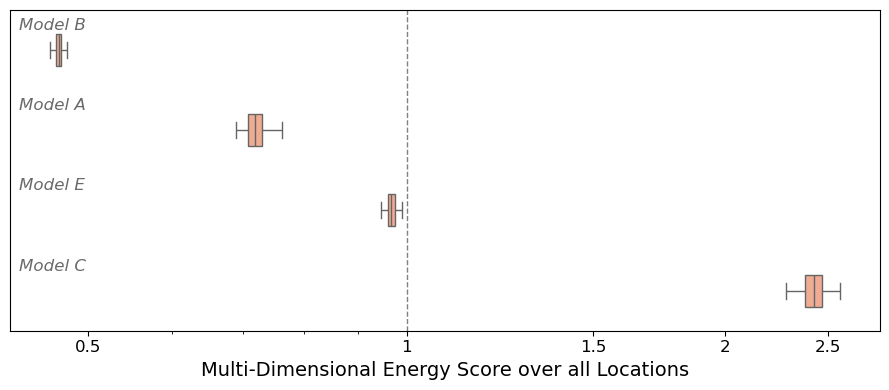

In [91]:
fig, ax = plt.subplots(1,1,figsize=(9,4), sharex=True)
mpl.rc_file_defaults()

baseline_locations = pd.read_pickle('../fludat/flu-baseline_energyscore_multidim.pkl')
baseline_avg = baseline_locations.energyscore.mean()

energyscores_locall['energyscore_ratio'] = energyscores_locall['energyscore'] / baseline_avg


df= energyscores_locall[(energyscores_locall.Model != 'PSI-M2') & (energyscores_locall.Model != 'UT-ImmunoSEIRS')]

my_order = df.groupby(by=["Model"])["energyscore_ratio"].median().sort_values(ascending=True).index
ges = sns.boxplot(x='energyscore_ratio', y='Model', data=df, width=.4,order=my_order, 
            showfliers=False, color='coral')
plt.ylabel('')
plt.xlabel('Multi-Dimensional Energy Score over all Locations', fontsize=14)

ax.axvline(1, ymin=0, ymax=1, color='gray', linestyle='--', linewidth=1)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .7))
    
#sns.swarmplot(x='energyscore', y='Model', data=df, order=my_order, color='coral', orient='h',size=1,alpha=.95)

ges.set(yticklabels=[], xticklabels=[])
ges.set(yticks=[],xticks=[])
ges.set(ylabel=None)
#ges.set(xlabel=None)

#ges.set(xticks=[20, 40, 60, 80], xticklabels=[20, 40, 60, 80])
#ges.set(xticklabels=[])
#plt.xlim([10,90])

a = 0
for mod in list(my_order):
    plt.text(.43,a-.25, modelmap[mod], fontsize=12, style='italic', color='dimgray')
    a+=1


plt.xscale('log')
plt.xticks([])
plt.xticks([.5,1,1.5,2,2.5], labels=[.5,1,1.5,2,2.5], fontsize=12)
#plt.xticks([.5,1,1.5,2,2.5], fontsize=12)

plt.gca().xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

#plt.xlim([14.5,90])
#plt.xticks([20, 30,40, 50,60,70, 80], fontsize=13)
#ges.set(xticks=[20, 30,40, 50,60,70, 80], xticklabels=[20, 30,40, 50,60,70, 80])
plt.tight_layout()

plt.savefig('../figs/multitarget_locations_models_baseline.pdf')
plt.show()

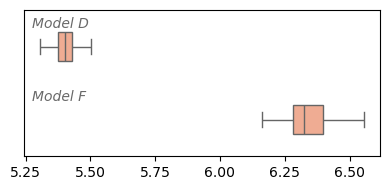

In [89]:
fig, ax = plt.subplots(1,1,figsize=(4,2), sharex=True)

df= energyscores_locall[(energyscores_locall.Model.isin(['PSI-M2', 'UT-ImmunoSEIRS'])) ]

my_order = df.groupby(by=["Model"])["energyscore_ratio"].median().sort_values(ascending=True).index
ges = sns.boxplot(x='energyscore_ratio', y='Model', data=df, width=.4,order=my_order, 
            showfliers=False, color='coral')

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .7))


plt.ylabel('')
plt.xlabel('')


ges.set(yticklabels=[])
ges.set(yticks=[])
ges.set(ylabel=None)
#ges.set(xlabel=None)
#ges.set(xticklabels=[])
#ges.set(xticks=[20, 40, 60, 80])
#plt.xlim([10,225])

a = 0
for mod in list(my_order):
    plt.text(5.275,a-.25, modelmap[mod], fontsize=10, style='italic', color='dimgray')
    a+=1

#plt.xscale('log')
plt.xticks([5.25,5.5,5.75,6,6.25,6.5])

#plt.xlim([150,225])

plt.tight_layout()
plt.savefig('../figs/multitarget_locations_models_baseline_inset.pdf')

plt.show()

In [124]:
from numba import njit
@njit
def energyscore_terms_norm(X,y):
    # X is matrix of trajectories, y is observations
    ES1 = 0
    ES2 = 0
    N = X.shape[0]
    for i in range(N):
        ES1+=np.sqrt(np.sum(((X[i]-y)/y)**2))/N
    for i in range(N):
        for j in range(N):
            ES2 -= np.sqrt(np.sum(((X[i]-X[j])/y)**2))/(2*N**2)
    return ES1, ES2


In [125]:

energyscores_locations = pd.DataFrame()
for it in range(100):
    for model in ['MOBS_NEU-GLEAM_FLU']:
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:

            loc_array ={}
            j=0
            for loc in locations:
                if loc in ['72', '66']:
                    continue
                predictionshosp = dfmobs[(dfmobs.scenario_id == scenario + '-2023-08-14') & \
                                            (dfmobs.target_end_date <= hosp.date.max()) & \
                                            (dfmobs.target_end_date >= hosp.date.min())&\
                                            (dfmobs.Model == model) &\
                                            (dfmobs.location==loc)]

                newid = random.sample(list(predictionshosp['trajectory_id']), 
                                      k=len(list(predictionshosp['trajectory_id'])))
                predictionshosp['new_id'] = newid

                Xhosp = np.array([np.array(predictionshosp[predictionshosp.new_id == i].value) for \
                         i in predictionshosp.new_id.unique()])
                
                loc_array[loc] = Xhosp
                
                j+=1
                
            A = []
            for i in range(len(Xhosp)):
                B = []
                for loc in locations:
                    if loc in ['72', '66']:
                        continue
                    B.append(loc_array[loc][i])
                B = np.array(B)
                A.append(B)

            A = np.array(A)



            ES1,ES2 = energyscore_terms_norm(A,obs)


            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':'US',  
                                 'term1': ES1,'term2':ES2, 'it':it}, index=[0])

            energyscores_locations = pd.concat([energyscores_locations, newrow])

energyscores_locations = energyscores_locations.reset_index().drop(columns=['index'])  

KeyboardInterrupt: 

In [126]:
energyscores_locations

,Model,Label,location,term1,term2,it
0,MOBS_NEU-GLEAM_FLU,Scenario A,US,48.237542,-26.615024,0
0,MOBS_NEU-GLEAM_FLU,Scenario B,US,41.867669,-20.442840,0
0,MOBS_NEU-GLEAM_FLU,Scenario C,US,55.209790,-29.566727,0
0,MOBS_NEU-GLEAM_FLU,Scenario D,US,47.197836,-23.578198,0
0,MOBS_NEU-GLEAM_FLU,Scenario E,US,56.804398,-29.687930,0
...,...,...,...,...,...,...
0,MOBS_NEU-GLEAM_FLU,Scenario A,US,49.496365,-27.505107,65
0,MOBS_NEU-GLEAM_FLU,Scenario B,US,42.973611,-21.535441,65
0,MOBS_NEU-GLEAM_FLU,Scenario C,US,55.076319,-29.435264,65
0,MOBS_NEU-GLEAM_FLU,Scenario D,US,48.696406,-24.617276,65


Text(0, 0.5, 'Second term- Sharpness')

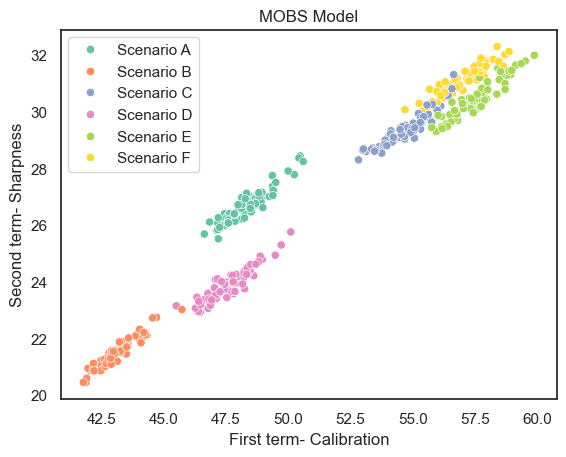

In [137]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
sns.scatterplot(x=energyscores_locations.term1, y=[-i for i in energyscores_locations.term2],hue='Label',
                data = energyscores_locations, palette='Set2')
plt.legend(facecolor='w')
plt.title('MOBS Model')
plt.xlabel('First term- Calibration')
plt.ylabel('Second term- Sharpness')

# Correlation with sum

In [139]:
energyscoresdf = pd.read_pickle("../fludat/energyscore_individual_rd4_hosp_521.pkl")

In [145]:
ESdf_sum = energyscoresdf.groupby(['Label','Model','target']).sum().rename(columns={'energyscore':'ES_sum'})
ESdf_sum.to_csv('../fludat/ESdf_sum.csv')

In [151]:
ESdf_sum = pd.read_csv('../fludat/ESdf_sum.csv')
energyscores_locations = pd.read_csv('../fludat/multitarget_loc_MOBS.csv')
ESall = energyscores_locations.merge(ESdf_sum,on=['Model', 'Label'])

In [152]:
ESall

,Unnamed: 0,Model,Label,location,energyscore,it,target,ES_sum,population
0,0,MOBS_NEU-GLEAM_FLU,Scenario A,US,21.729432,0,hosp,55527.933036,657456932
1,6,MOBS_NEU-GLEAM_FLU,Scenario A,US,22.371091,1,hosp,55527.933036,657456932
2,12,MOBS_NEU-GLEAM_FLU,Scenario A,US,22.317181,2,hosp,55527.933036,657456932
3,18,MOBS_NEU-GLEAM_FLU,Scenario A,US,21.567744,3,hosp,55527.933036,657456932
4,24,MOBS_NEU-GLEAM_FLU,Scenario A,US,21.493061,4,hosp,55527.933036,657456932
...,...,...,...,...,...,...,...,...,...
595,575,MOBS_NEU-GLEAM_FLU,Scenario F,US,26.537038,95,hosp,46049.295344,657456932
596,581,MOBS_NEU-GLEAM_FLU,Scenario F,US,25.669630,96,hosp,46049.295344,657456932
597,587,MOBS_NEU-GLEAM_FLU,Scenario F,US,25.314824,97,hosp,46049.295344,657456932
598,593,MOBS_NEU-GLEAM_FLU,Scenario F,US,25.745043,98,hosp,46049.295344,657456932


Text(0, 0.5, 'sum of energy score at each location')

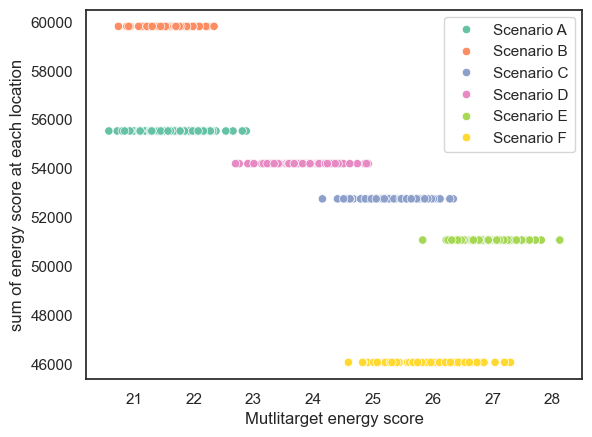

In [155]:
sns.scatterplot(x='energyscore', y='ES_sum', data=ESall, hue='Label', palette='Set2')
plt.legend(facecolor='w')
plt.xlabel('Mutlitarget energy score')
plt.ylabel('sum of energy score at each location')

In [158]:
# test with fake trajectories

In [167]:
def generative_process(T=20):
    x = [np.random.normal()]
    for t in range(1,T):
        x.append(x[0])
    return np.array(x)


def model_process(t=20):
    # generate each time step from standard normal distribution for t time steps
    x = np.random.normal(size=t)
    return x



def generative_trajectories(n=100, t=20):
    dates = pd.to_datetime(['2023-02-12','2023-02-19','2023-02-26','2023-03-04','2023-03-11', '2023-03-18', 
                            '2023-03-25' ,'2023-04-01', '2023-04-08' ,'2023-04-15' ,'2023-04-22', '2023-04-29', 
                            '2023-05-06', '2023-05-13', '2023-05-20', '2023-05-27',
                            '2023-06-03', '2023-06-10', '2023-06-17', '2023-06-24'])
    traj = pd.DataFrame()
    for j in range(n):
        v = []
        init = np.random.normal()
        for i in range(t):
            v.append(init)
        v1 = pd.DataFrame({'value':v, 'target_end_date':dates})
        v1['Model'] = 'generative'
        v1['trajectory_id'] = j
        
        traj = pd.concat([traj, v1])
    return traj



#def model_trajectories(n=100, t=20):
    
#    traj = np.array([model_process(t) for _ in range(n)])
    
#    return traj


def model_trajectories(n=100, t=20):
    dates = pd.to_datetime(['2023-02-12','2023-02-19','2023-02-26','2023-03-04','2023-03-11', '2023-03-18', 
                            '2023-03-25' ,'2023-04-01', '2023-04-08' ,'2023-04-15' ,'2023-04-22', '2023-04-29', 
                            '2023-05-06', '2023-05-13', '2023-05-20', '2023-05-27',
                            '2023-06-03', '2023-06-10', '2023-06-17', '2023-06-24'])
    traj = pd.DataFrame()
    for j in range(n):
        v = []
        for i in range(t):
            v.append(np.random.normal())
        
        v1 = pd.DataFrame({'value':v, 'target_end_date':dates})
        v1['Model'] = 'generative'
        v1['trajectory_id'] = j
        
        traj = pd.concat([traj, v1])
    return traj


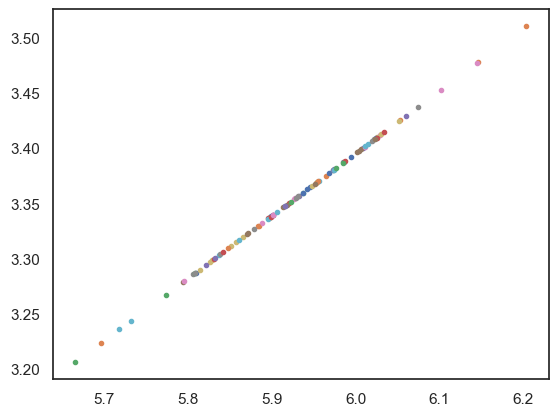

In [189]:
N=100
M=20
#g = model_trajectories()
y = generative_process(M)
for i in range(100):
    
    X1 = np.array([model_process(M) for _ in range(N)])
    ES=energyscore(X1,y)
    ESmt = energyscore_multipletargets(X1,y)
    
    plt.plot(ES,ESmt,'.')
    
plt.show()

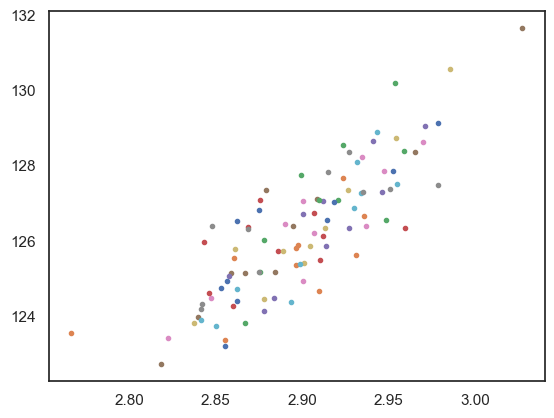

In [192]:
N=100
M=20
#g = model_trajectories()
y = generative_process(M)
for i in range(100):
    
    X1 = np.array([model_process(M) for _ in range(N)])
    X2 = np.array([model_process(M) for _ in range(N)])
    ES1=energyscore(X1,y)
    ES2=energyscore(X2,y)
    ESmt = energyscore_multipletargets(np.array([X1,X2]),y)
    
    plt.plot(ES1+ES2,ESmt,'.')
    
plt.show()

In [224]:
N=100
M=20
#g = model_trajectories()
y = generative_process(M)

ESmt_dict = {}
ESsum_dict = {}
for z in range(20):
    ESmt_dict[z] =[]
    
    mts = []
    es = []
    
    
    dfall = pd.DataFrame()
    for targ in range(50):
        df = model_trajectories()
        df['target'] = targ
        dfall = pd.concat([dfall, df])
    
    
    for targ in dfall.target.unique():
        dffilt = dfall[dfall.target==targ]
        X = [np.array(dffilt[dffilt['trajectory_id'] == i].value) for i in dffilt['trajectory_id'].unique()]
        ES = energyscore(np.array(X),y)
        es.append(ES)
        
    ESsum_dict[z] = np.sum(es)

    loc_array={}
    for it in range(20):
        for targ in dfall.target.unique():
            dffilt = dfall[dfall.target==targ]

            newid = random.sample(list(dffilt['trajectory_id']), 
                                              k=len(list(dffilt['trajectory_id'])))
            dffilt['new_id'] = newid

            X = np.array([np.array(dffilt[dffilt.new_id == i].value) for \
                     i in dffilt.new_id.unique()])
            loc_array[targ] = X


        A = []
        for i in range(len(X)):
            B = []
            for loc in loc_array.keys():
                B.append(loc_array[loc][i])
            B = np.array(B)
            A.append(B)

        A = np.array(A)



        ESmt = energyscore_multipletargets(A,y)
        ESmt_dict[z].append(ESmt)

    
    
    #plt.plot(np.sum(es),ESmt,'.')
    
    
#plt.show()

Text(0.5, 1.0, '50 targets')

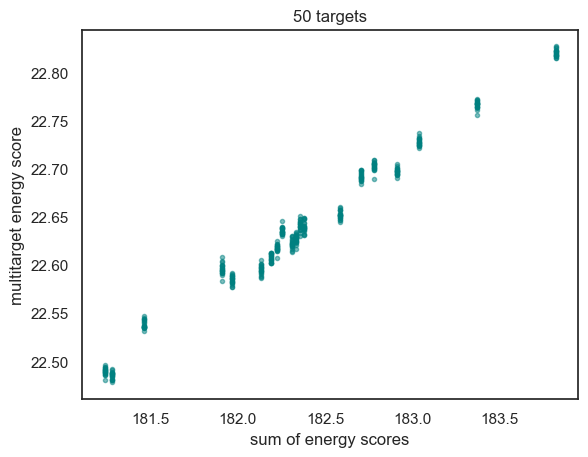

In [226]:
for k in list(ESmt_dict.keys()):
    for it in range(len(ESmt_dict[k])):
        plt.plot(ESsum_dict[k], ESmt_dict[k][it],'.', color='teal', alpha=0.5)
        
plt.xlabel('sum of energy scores')
plt.ylabel('multitarget energy score')
plt.title('50 targets')

In [227]:
N=100
M=20
#g = model_trajectories()
y = generative_process(M)

ESmt_dict = {}
ESsum_dict = {}
for z in range(20):
    ESmt_dict[z] =[]
    
    mts = []
    es = []
    
    
    dfall = pd.DataFrame()
    for targ in range(1):
        df = model_trajectories()
        df['target'] = targ
        dfall = pd.concat([dfall, df])
    
    
    for targ in dfall.target.unique():
        dffilt = dfall[dfall.target==targ]
        X = [np.array(dffilt[dffilt['trajectory_id'] == i].value) for i in dffilt['trajectory_id'].unique()]
        ES = energyscore(np.array(X),y)
        es.append(ES)
        
    ESsum_dict[z] = np.sum(es)

    loc_array={}
    for it in range(20):
        for targ in dfall.target.unique():
            dffilt = dfall[dfall.target==targ]

            newid = random.sample(list(dffilt['trajectory_id']), 
                                              k=len(list(dffilt['trajectory_id'])))
            dffilt['new_id'] = newid

            X = np.array([np.array(dffilt[dffilt.new_id == i].value) for \
                     i in dffilt.new_id.unique()])
            loc_array[targ] = X


        A = []
        for i in range(len(X)):
            B = []
            for loc in loc_array.keys():
                B.append(loc_array[loc][i])
            B = np.array(B)
            A.append(B)

        A = np.array(A)



        ESmt = energyscore_multipletargets(A,y)
        ESmt_dict[z].append(ESmt)

    
    
    #plt.plot(np.sum(es),ESmt,'.')
    
    
#plt.show()

Text(0.5, 1.0, '1 target')

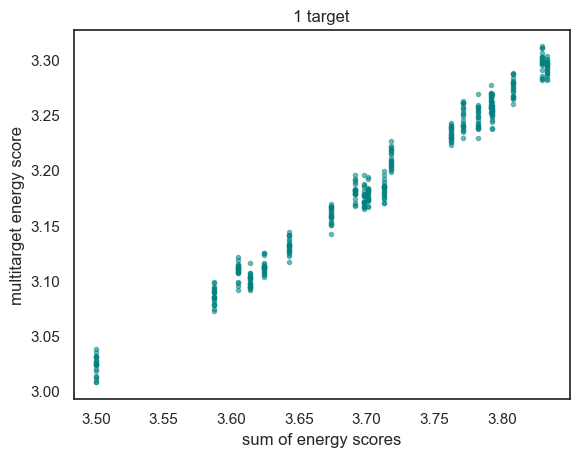

In [228]:
for k in list(ESmt_dict.keys()):
    for it in range(len(ESmt_dict[k])):
        plt.plot(ESsum_dict[k], ESmt_dict[k][it],'.', color='teal', alpha=0.5)
        
plt.xlabel('sum of energy scores')
plt.ylabel('multitarget energy score')
plt.title('1 target')

In [250]:
def model_trajectories(n=100, t=20,avg = 0,std=1):
    dates = pd.to_datetime(['2023-02-12','2023-02-19','2023-02-26','2023-03-04','2023-03-11', '2023-03-18', 
                            '2023-03-25' ,'2023-04-01', '2023-04-08' ,'2023-04-15' ,'2023-04-22', '2023-04-29', 
                            '2023-05-06', '2023-05-13', '2023-05-20', '2023-05-27',
                            '2023-06-03', '2023-06-10', '2023-06-17', '2023-06-24'])
    traj = pd.DataFrame()
    for j in range(n):
        v = []
        for i in range(t):
            v.append(np.random.normal(loc=avg,scale=std))
        
        v1 = pd.DataFrame({'value':v, 'target_end_date':dates})
        v1['Model'] = 'generative'
        v1['trajectory_id'] = j
        
        traj = pd.concat([traj, v1])
    return traj


N=100
M=20
#g = model_trajectories()


ESmt_dict = {}
ESsum_dict = {}
for z in range(20):
    y = generative_process(M)
    ESmt_dict[z] =[]
    
    mts = []
    es = []
    
    
    dfall = pd.DataFrame()
    for targ in range(50):
        df = model_trajectories(avg =0, std=1+0.5*targ)
        df['target'] = targ
        dfall = pd.concat([dfall, df])
    
    
    for targ in dfall.target.unique():
        dffilt = dfall[dfall.target==targ]
        X = [np.array(dffilt[dffilt['trajectory_id'] == i].value) for i in dffilt['trajectory_id'].unique()]
        ES = energyscore(np.array(X),y)
        es.append(ES)
        
    ESsum_dict[z] = np.sum(es)

    loc_array={}
    for it in range(20):
        for targ in dfall.target.unique():
            dffilt = dfall[dfall.target==targ]

            newid = random.sample(list(dffilt['trajectory_id']), 
                                              k=len(list(dffilt['trajectory_id'])))
            dffilt['new_id'] = newid

            X = np.array([np.array(dffilt[dffilt.new_id == i].value) for \
                     i in dffilt.new_id.unique()])
            loc_array[targ] = X


        A = []
        for i in range(len(X)):
            B = []
            for loc in loc_array.keys():
                B.append(loc_array[loc][i])
            B = np.array(B)
            A.append(B)

        A = np.array(A)



        ESmt = energyscore_multipletargets(A,y)
        ESmt_dict[z].append(ESmt)

    
    
    #plt.plot(np.sum(es),ESmt,'.')
    
    
#plt.show()

Text(0, 0.5, 'multitarget energy score')

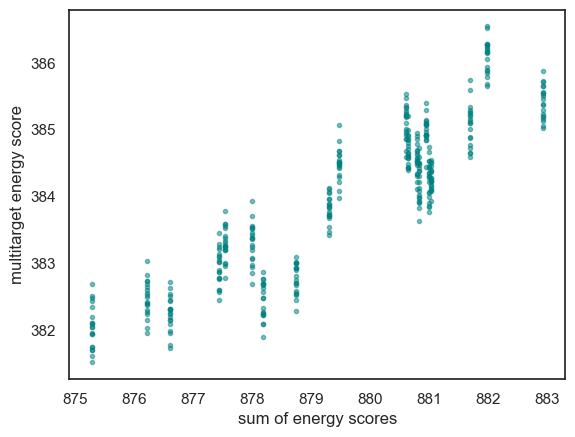

In [246]:
for k in list(ESmt_dict.keys()):
    plt.plot(ESsum_dict[k]*np.ones(len(ESmt_dict[k])), ESmt_dict[k],'.',color='teal', alpha=0.5)
        
plt.xlabel('sum of energy scores')
plt.ylabel('multitarget energy score')
#plt.title('50 targets')

Text(0, 0.5, 'multitarget energy score')

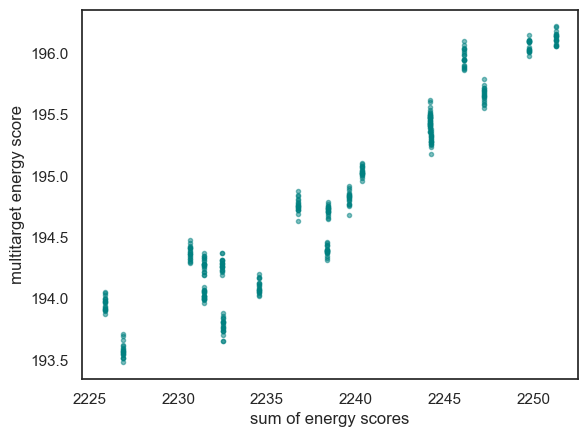

In [248]:
for k in list(ESmt_dict.keys()):
    plt.plot(ESsum_dict[k]*np.ones(len(ESmt_dict[k])), ESmt_dict[k],'.',color='teal', alpha=0.5)
        
plt.xlabel('sum of energy scores')
plt.ylabel('multitarget energy score')
#plt.title('10 targets')

In [256]:
dfmobs = predictionsall[(predictionsall.Model=='PSI-M2') & (predictionsall.target=='inc hosp')]
energyscores_locations = pd.DataFrame()
for it in range(100):
    for model in ['PSI-M2']:
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:

            loc_array ={}
            j=0
            for loc in locations:
                if loc in ['72', '66']:
                    continue
                predictionshosp = dfmobs[(dfmobs.scenario_id == scenario + '-2023-08-14') & \
                                            (dfmobs.target_end_date <= hosp.date.max()) & \
                                            (dfmobs.target_end_date >= hosp.date.min())&\
                                            (dfmobs.Model == model) &\
                                            (dfmobs.location==loc)]

                newid = random.sample(list(predictionshosp['trajectory_id']), 
                                      k=len(list(predictionshosp['trajectory_id'])))
                predictionshosp['new_id'] = newid

                Xhosp = np.array([np.array(predictionshosp[predictionshosp.new_id == i].value) for \
                         i in predictionshosp.new_id.unique()])
                
                loc_array[loc] = Xhosp
                
                j+=1
                
            A = []
            for i in range(len(Xhosp)):
                B = []
                for loc in locations:
                    if loc in ['72', '66']:
                        continue
                    B.append(loc_array[loc][i])
                B = np.array(B)
                A.append(B)

            A = np.array(A)



            ES = energyscore_multipletargets(A,obs)


            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':'US',  
                                 'energyscore': ES, 'it':it}, index=[0])

            energyscores_locations = pd.concat([energyscores_locations, newrow])

energyscores_psi = energyscores_locations.reset_index().drop(columns=['index'])  

5.59115997575739
4.499229421228101
6.8770868488761225
5.405904647123021
8.607989989459433
6.347093481431477


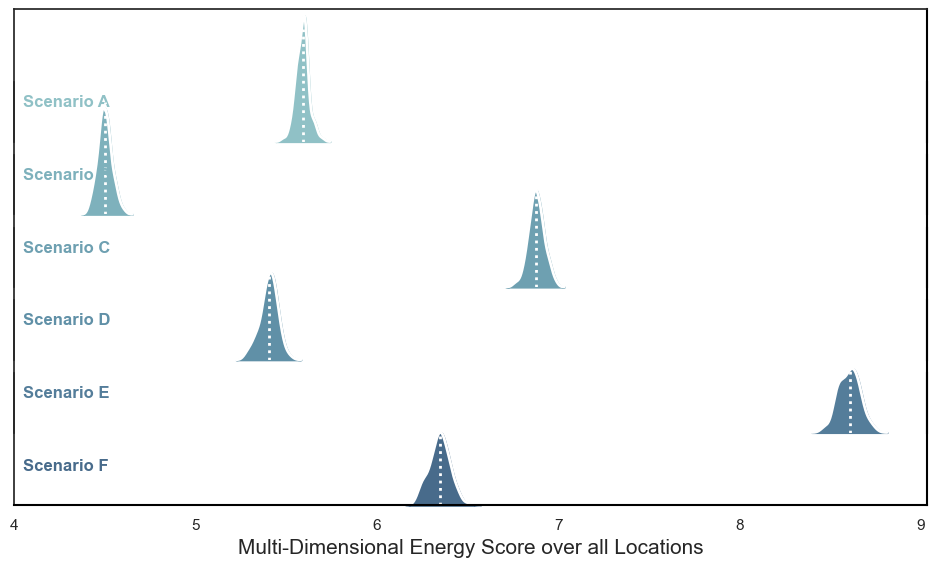

In [265]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

energyscores_locations = energyscores_psi.copy()
baseline_locations = pd.read_pickle('../fludat/flu-baseline_energyscore_multidim.pkl')
baseline_avg = baseline_locations.energyscore.mean()

energyscores_locations['energyscore_ratio'] = energyscores_locations['energyscore'] / baseline_avg

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(energyscores_locations, row="Label", hue="Label", aspect=10, height=1, palette=pal)

#for ax in g.axes.flat:
    
    # Plot a vertical line at x=20 for each subplot
 #   ax.axvline(1,ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
  #  ax.axvline(.65,ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
   # ax.axvline(.75,ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
    #ax.axvline(.85, ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
    #ax.axvline(28, ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)




# Draw the densities in a few steps
g.map(sns.kdeplot, "energyscore_ratio",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "energyscore_ratio", clip_on=False, color="w", lw=2, bw_adjust=1)

# passing color=None to refline() uses the hue mapping
#g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(.01, .3, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "energyscore")

# Define a function to plot the median
def plot_median(data, color, label):
    median = np.median(data['energyscore_ratio'])
    plt.axvline(median,ymin=0, ymax=.85, color='white', linestyle=':', linewidth=2)
    print(median)
    

# Apply the function to plot the median
g.map_dataframe(plot_median)


# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xticks=[4,5,6,7,8,9])
#g.set_xticklabels([20, 22, 24, 26, 28])
#g.despine(bottom=True, left=True)


g.despine(bottom=True, left=False)
# Add a box around the full figure
#g.fig.patch.set_edgecolor('black')  # Set the edge color to black
#g.fig.patch.set_linewidth(2)        # Set the line width of the box

i=0

#g.set(xlim=[19, 29])

for ax in g.axes.flat:
    if i==0:
        ax.spines['top'].set_visible(True)
    elif i==1:
        ax.set_xticks([4,5,6,7,8,9])  # Set custom tick locations
        ax.set_xticklabels([4,5,6,7,8,9], fontsize=13)  # Set custom tick labels and fontsize

    ax.spines['right'].set_visible(True)
    ax.spines['right'].set_edgecolor('black')
    ax.spines['right'].set_linewidth(1.5)
    
    if i==5:
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_edgecolor('black')
        ax.spines['bottom'].set_linewidth(1.5)


    i+=1

#plt.xlim([-45, 32])
plt.xlabel('Multi-Dimensional Energy Score over all Locations', fontsize=15)

#plt.xticks([20,22,24,26,28],fontsize=13)

#plt.xticks([20,22,24,26,28])

#g.set_xticks([.2,.4,.6,.8,1,1.2,1.4,1.6,1.8,2])  # Set custom tick locations
#g.set_xticklabels([.2,.4,.6,.8,1,1.2,1.4,1.6,1.8,2], fontsize=13)  # Set custom tick labels and fontsize
#g.set(xticks=[20,22,24,26,28])

#plt.ylabel('% infectious-detectable \n stopped '+r'from traveling, $\phi_b$', y=1.1, fontsize=12)

#plt.savefig('../figs/multitarget_MOBS_kdeplot_baseline.pdf')
plt.show()

Text(0, 0.5, 'sum of energy score at each location')

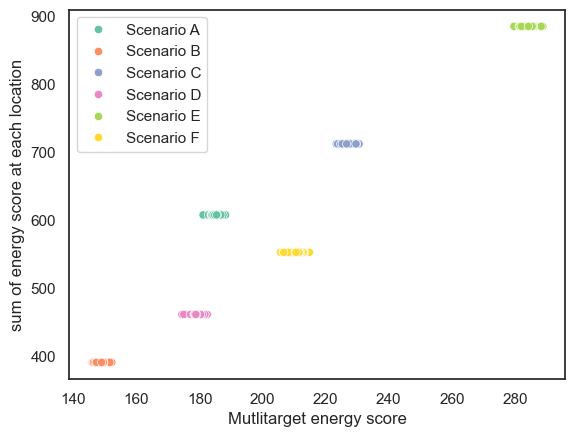

In [266]:
ESdf_sum = energyscoresdf.groupby(['Label','Model','target']).sum().rename(columns={'energyscore':'ES_sum'})
ESdf_sum.to_csv('../fludat/ESdf_sum.csv')
ESdf_sum = pd.read_csv('../fludat/ESdf_sum.csv')
#energyscores_locations = pd.read_csv('../fludat/multitarget_loc_MOBS.csv')
ESall = energyscores_psi.merge(ESdf_sum,on=['Model', 'Label'])

sns.scatterplot(x='energyscore', y='ES_sum', data=ESall, hue='Label', palette='Set2')
plt.legend(facecolor='w')
plt.xlabel('Mutlitarget energy score')
plt.ylabel('sum of energy score at each location')

In [278]:
dfmobs = predictionsall[(predictionsall.Model=='UT-ImmunoSEIRS') & (predictionsall.target=='inc hosp')]
energyscores_locations = pd.DataFrame()

obs = np.array([np.array(hosp[hosp.location == i].value) for \
                     i in dfmobs.location.unique()])
locations = list(dfmobs.location.unique())

for it in range(100):
    for model in ['UT-ImmunoSEIRS']:
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:

            loc_array ={}
            j=0
            for loc in locations:
                if loc in ['72', '66']:
                    continue
                predictionshosp = dfmobs[(dfmobs.scenario_id == scenario + '-2023-08-14') & \
                                            (dfmobs.target_end_date <= hosp.date.max()) & \
                                            (dfmobs.target_end_date >= hosp.date.min())&\
                                            (dfmobs.Model == model) &\
                                            (dfmobs.location==loc)]

                newid = random.sample(list(predictionshosp['trajectory_id']), 
                                      k=len(list(predictionshosp['trajectory_id'])))
                predictionshosp['new_id'] = newid

                Xhosp = np.array([np.array(predictionshosp[predictionshosp.new_id == i].value) for \
                         i in predictionshosp.new_id.unique()])
                
                loc_array[loc] = Xhosp
                
                j+=1
                
            A = []
            for i in range(len(Xhosp)):
                B = []
                for loc in locations:
                    if loc in ['72', '66']:
                        continue
                    B.append(loc_array[loc][i])
                B = np.array(B)
                A.append(B)

            A = np.array(A)



            ES = energyscore_multipletargets(A,obs)


            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':'US',  
                                 'energyscore': ES, 'it':it}, index=[0])

            energyscores_locations = pd.concat([energyscores_locations, newrow])

energyscores_ut = energyscores_locations.reset_index().drop(columns=['index'])  

6.787911760033432
6.552727324736652
6.563746307574453
6.324100944285821
6.505633138360471
6.979120800271315


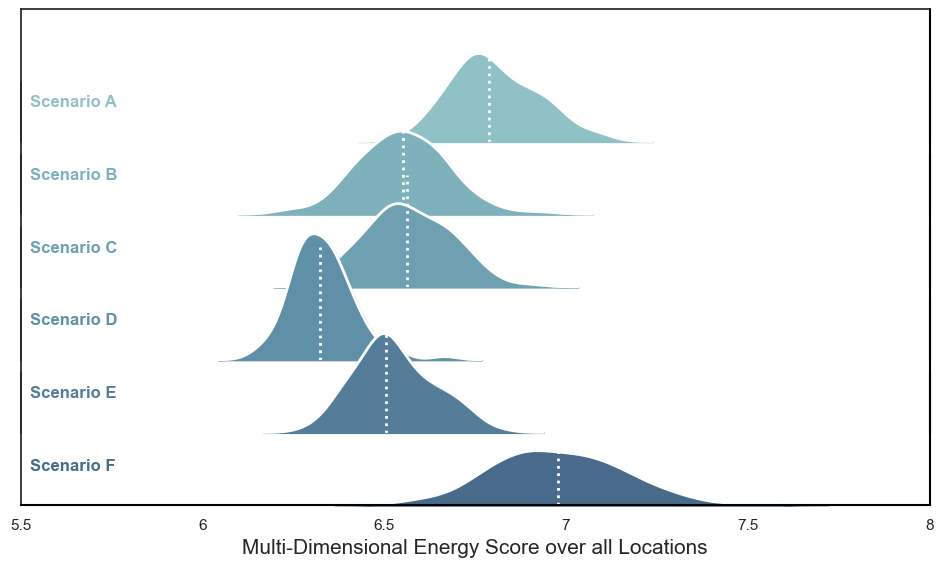

In [280]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

energyscores_locations = energyscores_ut.copy()
baseline_locations = pd.read_pickle('../fludat/flu-baseline_energyscore_multidim.pkl')
baseline_avg = baseline_locations.energyscore.mean()

energyscores_locations['energyscore_ratio'] = energyscores_locations['energyscore'] / baseline_avg

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(energyscores_locations, row="Label", hue="Label", aspect=10, height=1, palette=pal)

#for ax in g.axes.flat:
    
    # Plot a vertical line at x=20 for each subplot
 #   ax.axvline(1,ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
  #  ax.axvline(.65,ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
   # ax.axvline(.75,ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
    #ax.axvline(.85, ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
    #ax.axvline(28, ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)




# Draw the densities in a few steps
g.map(sns.kdeplot, "energyscore_ratio",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "energyscore_ratio", clip_on=False, color="w", lw=2, bw_adjust=1)

# passing color=None to refline() uses the hue mapping
#g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(.01, .3, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "energyscore")

# Define a function to plot the median
def plot_median(data, color, label):
    median = np.median(data['energyscore_ratio'])
    plt.axvline(median,ymin=0, ymax=.85, color='white', linestyle=':', linewidth=2)
    print(median)
    

# Apply the function to plot the median
g.map_dataframe(plot_median)


# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xticks=[5.5,6,6.5,7,7.5,8])
#g.set_xticklabels([20, 22, 24, 26, 28])
#g.despine(bottom=True, left=True)


g.despine(bottom=True, left=False)
# Add a box around the full figure
#g.fig.patch.set_edgecolor('black')  # Set the edge color to black
#g.fig.patch.set_linewidth(2)        # Set the line width of the box

i=0

#g.set(xlim=[19, 29])

for ax in g.axes.flat:
    if i==0:
        ax.spines['top'].set_visible(True)
    elif i==1:
        ax.set_xticks([5.5,6,6.5,7,7.5,8])  # Set custom tick locations
        ax.set_xticklabels([5.5,6,6.5,7,7.5,8], fontsize=13)  # Set custom tick labels and fontsize

    ax.spines['right'].set_visible(True)
    ax.spines['right'].set_edgecolor('black')
    ax.spines['right'].set_linewidth(1.5)
    
    if i==5:
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_edgecolor('black')
        ax.spines['bottom'].set_linewidth(1.5)


    i+=1

#plt.xlim([-45, 32])
plt.xlabel('Multi-Dimensional Energy Score over all Locations', fontsize=15)

#plt.xticks([20,22,24,26,28],fontsize=13)

#plt.xticks([20,22,24,26,28])

#g.set_xticks([.2,.4,.6,.8,1,1.2,1.4,1.6,1.8,2])  # Set custom tick locations
#g.set_xticklabels([.2,.4,.6,.8,1,1.2,1.4,1.6,1.8,2], fontsize=13)  # Set custom tick labels and fontsize
#g.set(xticks=[20,22,24,26,28])

#plt.ylabel('% infectious-detectable \n stopped '+r'from traveling, $\phi_b$', y=1.1, fontsize=12)

#plt.savefig('../figs/multitarget_MOBS_kdeplot_baseline.pdf')
plt.show()

Text(0, 0.5, 'sum of energy score at each location')

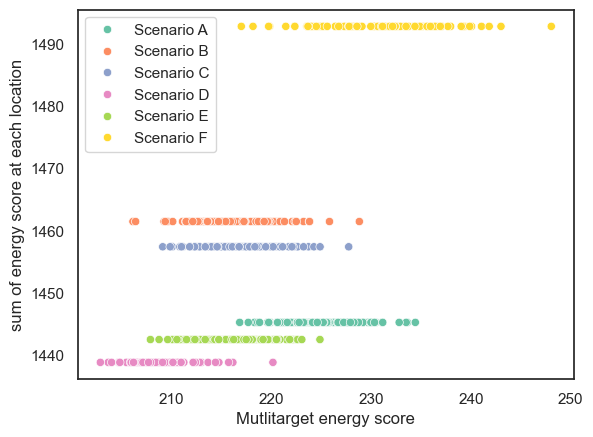

In [281]:
ESdf_sum = energyscoresdf.groupby(['Label','Model','target']).sum().rename(columns={'energyscore':'ES_sum'})
ESdf_sum.to_csv('../fludat/ESdf_sum.csv')
ESdf_sum = pd.read_csv('../fludat/ESdf_sum.csv')
#energyscores_locations = pd.read_csv('../fludat/multitarget_loc_MOBS.csv')
ESall = energyscores_ut.merge(ESdf_sum,on=['Model', 'Label'])

sns.scatterplot(x='energyscore', y='ES_sum', data=ESall, hue='Label', palette='Set2')
plt.legend(facecolor='w')
plt.xlabel('Mutlitarget energy score')
plt.ylabel('sum of energy score at each location')

In [341]:
# multitarget terms

energyscores_locations = pd.DataFrame()
for it in range(10):
    for model in ['MOBS_NEU-GLEAM_FLU', 'PSI-M2']:
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:

            loc_array ={}
            j=0
            for loc in predictionsall[predictionsall.Model==model].location.unique():
                if loc in ['72', '66']:
                    continue
                predictionshosp = predictionsall[(predictionsall.scenario_id == scenario + '-2023-08-14') & \
                                            (predictionsall.target_end_date <= hosp.date.max()) & \
                                            (predictionsall.target_end_date >= hosp.date.min())&\
                                            (predictionsall.Model == model) &\
                                            (predictionsall.location==loc) &\
                                            (predictionsall.target=='inc hosp')]
                if len(predictionshosp)==0:
                    continue

                newid = random.sample(list(predictionshosp['trajectory_id']), 
                                      k=len(list(predictionshosp['trajectory_id'])))
                predictionshosp['new_id'] = newid

                Xhosp = np.array([np.array(predictionshosp[predictionshosp.new_id == i].value) for \
                         i in predictionshosp.new_id.unique()])
                
                loc_array[loc] = Xhosp
                
                j+=1
                
            A = []
            for i in range(len(Xhosp)):
                B = []
                for loc in locations:
                    if loc in ['72', '66']:
                        continue
                    B.append(loc_array[loc][i])
                B = np.array(B)
                A.append(B)

            A = np.array(A)

            obs = np.array([np.array(hosp[hosp.location == i].value) for \
                     i in predictionsall[predictionsall.Model==model].location.unique()])


            ES1,ES2 = energyscore_terms_norm(A,obs)


            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':'US',  
                                 'term1': ES1,'term2':ES2, 'it':it}, index=[0])

            energyscores_locations = pd.concat([energyscores_locations, newrow])

energyscores_locations = energyscores_locations.reset_index().drop(columns=['index'])  

In [344]:
energyscores_locations_testall = energyscores_locations.copy()

In [381]:
energyscores_locations_testall['term2'] = -1*energyscores_locations_testall['term2']

In [362]:
# calculate energy score for each week and plot
target = 'hospitalization'
incidence=True
observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target}.pq")

energyscores_terms = pd.DataFrame()

for model in ['MOBS_NEU-GLEAM_FLU', 'PSI-M2']:
    for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:


        for loc in predictionsall[predictionsall.Model==model].location.unique():
            if loc in ['72', '66']:
                continue
            predictionsfilt = predictionsall[(predictionsall.scenario_id == scenario + '-2023-08-14') & \
                                        (predictionsall.target_end_date <= hosp.date.max()) & \
                                        (predictionsall.target_end_date >= hosp.date.min())&\
                                        (predictionsall.Model == model) &\
                                        (predictionsall.location==loc) & (predictionsall.target=='inc hosp')]

        observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target}.pq")


        observations['date'] = pd.to_datetime(observations['date'])

        observations = observations[(observations['date'] >= start_week) & \
                                                (observations['date'] <= max_date)]   


        #aggregate to weekly
        observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

        #transform to Observation object
        observations = Observations(observations)

        #filter location
        observations = observations[(observations['location'] == loc) & (observations.date>=hosp.date.min())]

        y = np.array(observations.value)
        X = [np.array(predictionsfilt[predictionsfilt['output_type_id'] == i].value) for i in predictionsfilt['output_type_id'].unique()]


        ES1, ES2 = energyscore_terms_norm(np.array(X),y)


        newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':loc,  
                             'term1': ES1,'term2':ES2}, index=[0])

        energyscores_terms = pd.concat([energyscores_terms, newrow])

energyscores_terms = energyscores_terms.reset_index().drop(columns=['index'])  


In [365]:
energyscores_terms['term2'] = -1*energyscores_terms['term2']

In [369]:
energyscores_terms.groupby(by=['Model','Label']).sum().to_csv('../fludat/ESterms_mt_test_1028.csv')

In [382]:
energyscores_terms = pd.read_csv('../fludat/ESterms_mt_test_1028.csv')

df = energyscores_locations_testall.merge(energyscores_terms, on=['Model', 'Label'])

In [383]:
df

,Model,Label,location,term1_x,term2_x,it,term1_y,term2_y
0,MOBS_NEU-GLEAM_FLU,Scenario A,US,396.893491,197.319758,0,3.316220,1.393573
1,MOBS_NEU-GLEAM_FLU,Scenario A,US,391.303003,195.034853,1,3.316220,1.393573
2,MOBS_NEU-GLEAM_FLU,Scenario A,US,381.958121,189.630032,2,3.316220,1.393573
3,MOBS_NEU-GLEAM_FLU,Scenario A,US,390.041818,191.514480,3,3.316220,1.393573
4,MOBS_NEU-GLEAM_FLU,Scenario A,US,395.327802,195.770855,4,3.316220,1.393573
...,...,...,...,...,...,...,...,...
115,PSI-M2,Scenario F,US,1250.435370,397.160669,5,6.662503,0.504410
116,PSI-M2,Scenario F,US,1249.091692,404.355475,6,6.662503,0.504410
117,PSI-M2,Scenario F,US,1252.469251,401.644273,7,6.662503,0.504410
118,PSI-M2,Scenario F,US,1255.651000,394.816265,8,6.662503,0.504410


Text(0, 0.5, 'Calibration- sum of energy score over locations')

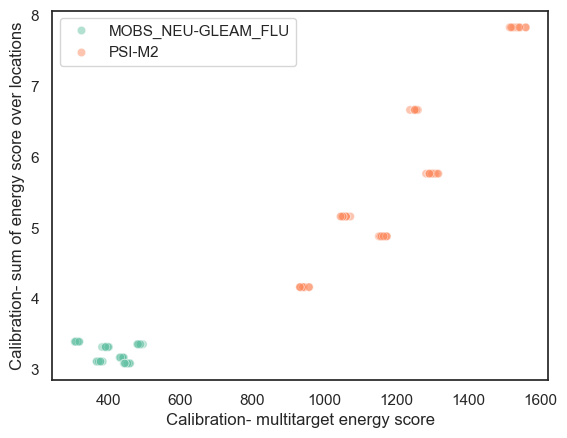

In [389]:
sns.scatterplot(x='term1_x', y='term1_y',data=df,hue='Model', alpha=.5,palette='Set2')
plt.legend(facecolor='w')

plt.xlabel('Calibration- multitarget energy score')
plt.ylabel('Calibration- sum of energy score over locations')



Text(0, 0.5, 'Sharpness- sum of energy score over locations')

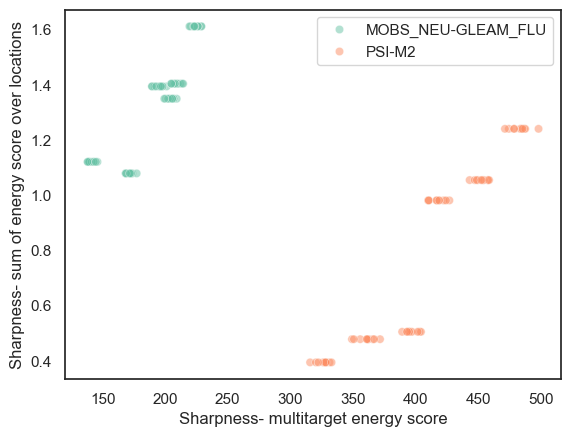

In [387]:
sns.scatterplot(x='term2_x', y='term2_y',data=df,hue='Model', alpha=.5,palette='Set2')
plt.legend(facecolor='w')

plt.xlabel('Sharpness- multitarget energy score')
plt.ylabel('Sharpness- sum of energy score over locations')

In [415]:
# test number of states?
dfmobs = dfmobs[~dfmobs.location.isin(['02', '10','15','33','49'])]

In [427]:
energyscores_locations = pd.DataFrame()
obs = np.array([np.array(hosp[hosp.location == i].value) for \
                     i in dfmobs.location.unique()])
for it in range(25):
    for model in ['MOBS_NEU-GLEAM_FLU']:
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:

            loc_array ={}
            j=0
            for loc in dfmobs.location.unique():
                if loc in ['72', '66']:
                    continue
                predictionshosp = dfmobs[(dfmobs.scenario_id == scenario + '-2023-08-14') & \
                                            (dfmobs.target_end_date <= hosp.date.max()) & \
                                            (dfmobs.target_end_date >= hosp.date.min())&\
                                            (dfmobs.Model == model) &\
                                            (dfmobs.location==loc)]

                newid = random.sample(list(predictionshosp['trajectory_id']), 
                                      k=len(list(predictionshosp['trajectory_id'])))
                predictionshosp['new_id'] = newid

                Xhosp = np.array([np.array(predictionshosp[predictionshosp.new_id == i].value) for \
                         i in predictionshosp.new_id.unique()])
                
                loc_array[loc] = Xhosp
                
                j+=1
                
            A = []
            for i in range(len(Xhosp)):
                B = []
                for loc in dfmobs.location.unique():
                    if loc in ['72', '66']:
                        continue
                    B.append(loc_array[loc][i])
                B = np.array(B)
                A.append(B)

            A = np.array(A)



            ES = energyscore_multipletargets(A,obs)


            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':'US',  
                                 'energyscore': ES, 'it':it}, index=[0])

            energyscores_locations = pd.concat([energyscores_locations, newrow])

energyscores_locations = energyscores_locations.reset_index().drop(columns=['index'])  

In [428]:
energyscores_locations

,Model,Label,location,energyscore,it
0,MOBS_NEU-GLEAM_FLU,Scenario A,US,14.487929,0
1,MOBS_NEU-GLEAM_FLU,Scenario B,US,16.816960,0
2,MOBS_NEU-GLEAM_FLU,Scenario C,US,15.228803,0
3,MOBS_NEU-GLEAM_FLU,Scenario D,US,15.750699,0
4,MOBS_NEU-GLEAM_FLU,Scenario E,US,15.923669,0
...,...,...,...,...,...
145,MOBS_NEU-GLEAM_FLU,Scenario B,US,16.694672,24
146,MOBS_NEU-GLEAM_FLU,Scenario C,US,15.193766,24
147,MOBS_NEU-GLEAM_FLU,Scenario D,US,15.718418,24
148,MOBS_NEU-GLEAM_FLU,Scenario E,US,15.865034,24


14.437372834293654
16.777664097972828
15.219091337816286
15.716235236453796
15.853575427633643
16.74611134342692


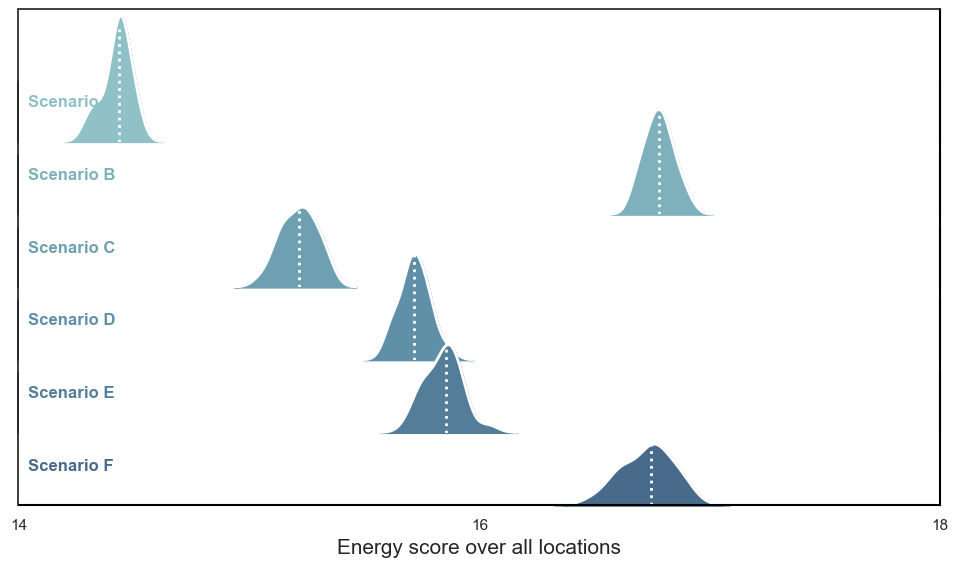

In [434]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

#energyscores_locations = pd.read_csv('../fludat/multitarget_loc_MOBS.csv')
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(energyscores_locations, row="Label", hue="Label", aspect=10, height=1, palette=pal)


#for ax in g.axes.flat:
    
    # Plot a vertical line at x=20 for each subplot
   # ax.axvline(20,ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
 #   ax.axvline(22,ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
  #  ax.axvline(24,ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
   # ax.axvline(26, ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
    #ax.axvline(28, ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)




# Draw the densities in a few steps
g.map(sns.kdeplot, "energyscore",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "energyscore", clip_on=False, color="w", lw=2, bw_adjust=1)

# passing color=None to refline() uses the hue mapping
#g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(.01, .3, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "energyscore")

# Define a function to plot the median
def plot_median(data, color, label):
    median = np.median(data['energyscore'])
    plt.axvline(median,ymin=0, ymax=.85, color='white', linestyle=':', linewidth=2)
    print(median)
    

# Apply the function to plot the median
g.map_dataframe(plot_median)


# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xticks=[14,16,18])
g.set_xticklabels([14,16,18])
#g.despine(bottom=True, left=True)


g.despine(bottom=True, left=False)
# Add a box around the full figure
#g.fig.patch.set_edgecolor('black')  # Set the edge color to black
#g.fig.patch.set_linewidth(2)        # Set the line width of the box

i=0

#g.set(xlim=[19, 29])

for ax in g.axes.flat:
    if i==0:
        ax.spines['top'].set_visible(True)
   # elif i==1:
      #  ax.set_xticks([20, 22, 24, 26, 28])  # Set custom tick locations
      #  ax.set_xticklabels([20, 22, 24, 26, 28], fontsize=13)  # Set custom tick labels and fontsize

    ax.spines['right'].set_visible(True)
    ax.spines['right'].set_edgecolor('black')
    ax.spines['right'].set_linewidth(1.5)
    
    if i==5:
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_edgecolor('black')
        ax.spines['bottom'].set_linewidth(1.5)


    i+=1

#plt.xlim([-45, 32])
plt.xlabel('Energy score over all locations', fontsize=15)

#plt.xticks([20,22,24,26,28],fontsize=13)

#plt.xticks([20,22,24,26,28])

#g.set_xticks([20, 22, 24, 26, 28])  # Set custom tick locations
#g.set_xticklabels([20, 22, 24, 26, 28], fontsize=13)  # Set custom tick labels and fontsize
#g.set(xticks=[20,22,24,26,28])

#plt.ylabel('% infectious-detectable \n stopped '+r'from traveling, $\phi_b$', y=1.1, fontsize=12)

#plt.savefig('../figs/multitarget_MOBS_kdeplot_1015.pdf')
plt.show()

In [467]:
# test number of states?
dfmobs = predictionsall[(predictionsall.Model=='MOBS_NEU-GLEAM_FLU') & (predictionsall.target=='inc hosp')]
dfmobs = dfmobs[dfmobs.location.isin(['US'])]

#hospitalizations
target = 'hospitalization'
incidence=True
hosp = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target}.pq")
hosp['date'] = pd.to_datetime(hosp['date'])
hosp = hosp[(hosp.date>pd.to_datetime('2023-09-09'))].sort_values(by=['date']).reset_index().drop(columns=\
                                                                        ['Unnamed: 0', 'index','weekly_rate'])

hosp = hosp[(hosp.location != '72') &(hosp.location!='66')]
#h = np.array(hosp['value'])
#obs = np.array([h,d])

In [497]:
energyscores_locations = pd.DataFrame()
obs = np.array([np.array(hosp[hosp.location == i].value) for \
                     i in dfmobs.location.unique()])
for it in range(5):
    for model in ['MOBS_NEU-GLEAM_FLU']:
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:

            loc_array ={}
            j=0
            for loc in dfmobs.location.unique():
                if loc in ['72', '66']:
                    continue
                predictionshosp = dfmobs[(dfmobs.scenario_id == scenario + '-2023-08-14') & \
                                            (dfmobs.target_end_date <= hosp.date.max()) & \
                                            (dfmobs.target_end_date >= hosp.date.min())&\
                                            (dfmobs.Model == model) &\
                                            (dfmobs.location==loc)]

                newid = random.sample(list(predictionshosp['trajectory_id']), 
                                      k=len(list(predictionshosp['trajectory_id'])))
                predictionshosp['new_id'] = newid

                Xhosp = np.array([np.array(predictionshosp[predictionshosp.new_id == i].value) for \
                         i in predictionshosp.new_id.unique()])
                
                loc_array[loc] = Xhosp
                
                j+=1
                
            A = []
            for i in range(len(Xhosp)):
                B = []
                for loc in dfmobs.location.unique():
                    if loc in ['72', '66']:
                        continue
                    B.append(loc_array[loc][i])
                B = np.array(B)
                A.append(B)

            A = np.array(A)



            ES = energyscore_multipletargets(A,obs)


            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':'US',  
                                 'energyscore': ES, 'it':it}, index=[0])

            energyscores_locations = pd.concat([energyscores_locations, newrow])

energyscores_locations = energyscores_locations.reset_index().drop(columns=['index'])  

In [514]:
predictionshosp

,origin_date,scenario_id,target,horizon,location,age_group,output_type,output_type_id,value,Model,trajectory_id,target_end_date,new_id
63400,2023-09-03,F-2023-08-14,inc hosp,2.0,US,0-130,sample,1,574.000,MOBS_NEU-GLEAM_FLU,1,2023-09-16,33
63401,2023-09-03,F-2023-08-14,inc hosp,2.0,US,0-130,sample,2,391.000,MOBS_NEU-GLEAM_FLU,2,2023-09-16,61
63402,2023-09-03,F-2023-08-14,inc hosp,2.0,US,0-130,sample,3,527.000,MOBS_NEU-GLEAM_FLU,3,2023-09-16,77
63403,2023-09-03,F-2023-08-14,inc hosp,2.0,US,0-130,sample,4,519.000,MOBS_NEU-GLEAM_FLU,4,2023-09-16,69
63404,2023-09-03,F-2023-08-14,inc hosp,2.0,US,0-130,sample,5,533.000,MOBS_NEU-GLEAM_FLU,5,2023-09-16,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081095,2023-09-03,F-2023-08-14,inc hosp,34.0,US,0-130,sample,96,2084.178,MOBS_NEU-GLEAM_FLU,96,2024-04-27,16
1081096,2023-09-03,F-2023-08-14,inc hosp,34.0,US,0-130,sample,97,640.458,MOBS_NEU-GLEAM_FLU,97,2024-04-27,14
1081097,2023-09-03,F-2023-08-14,inc hosp,34.0,US,0-130,sample,98,1077.945,MOBS_NEU-GLEAM_FLU,98,2024-04-27,92
1081098,2023-09-03,F-2023-08-14,inc hosp,34.0,US,0-130,sample,99,701.266,MOBS_NEU-GLEAM_FLU,99,2024-04-27,64


In [ ]:
newid

In [513]:
predictionshosp[predictionshosp.trajectory_id==1]

,origin_date,scenario_id,target,horizon,location,age_group,output_type,output_type_id,value,Model,trajectory_id,target_end_date,new_id
63400,2023-09-03,F-2023-08-14,inc hosp,2.0,US,0-130,sample,1,574.000,MOBS_NEU-GLEAM_FLU,1,2023-09-16,33
95200,2023-09-03,F-2023-08-14,inc hosp,3.0,US,0-130,sample,1,1257.751,MOBS_NEU-GLEAM_FLU,1,2023-09-23,31
127000,2023-09-03,F-2023-08-14,inc hosp,4.0,US,0-130,sample,1,2091.459,MOBS_NEU-GLEAM_FLU,1,2023-09-30,87
158800,2023-09-03,F-2023-08-14,inc hosp,5.0,US,0-130,sample,1,1478.321,MOBS_NEU-GLEAM_FLU,1,2023-10-07,48
190600,2023-09-03,F-2023-08-14,inc hosp,6.0,US,0-130,sample,1,2023.923,MOBS_NEU-GLEAM_FLU,1,2023-10-14,7
222400,2023-09-03,F-2023-08-14,inc hosp,7.0,US,0-130,sample,1,1731.289,MOBS_NEU-GLEAM_FLU,1,2023-10-21,5
254200,2023-09-03,F-2023-08-14,inc hosp,8.0,US,0-130,sample,1,2201.303,MOBS_NEU-GLEAM_FLU,1,2023-10-28,57
286000,2023-09-03,F-2023-08-14,inc hosp,9.0,US,0-130,sample,1,2249.835,MOBS_NEU-GLEAM_FLU,1,2023-11-04,99
317800,2023-09-03,F-2023-08-14,inc hosp,10.0,US,0-130,sample,1,2263.845,MOBS_NEU-GLEAM_FLU,1,2023-11-11,80
349600,2023-09-03,F-2023-08-14,inc hosp,11.0,US,0-130,sample,1,2703.371,MOBS_NEU-GLEAM_FLU,1,2023-11-18,37


In [498]:
energyscore_multipletargets(A, obs)

1.9201234349845069

In [489]:
@njit
def normalized_energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum(((X[i]-y)/y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum(((X[i]-X[j])/y)**2))/(2*N**2)
    return ES

In [499]:
normalized_energyscore(A,obs)

1.9201234349845069

In [500]:
energyscore(A,obs)

19501.127070609524

In [501]:
A = np.array([[50,55,54],[52,58,60]])
obs = np.array([54,60,58])
energyscore(A,obs)

3.7569680252042517

In [502]:
A = np.array([[52,58,60],[50,55,54]])
obs = np.array([54,60,58])
energyscore(A,obs)

3.7569680252042517

15.734024961756207
13.107805966675292
19.908959808072716
17.101486869442525
21.566134856342977
18.635110632237346


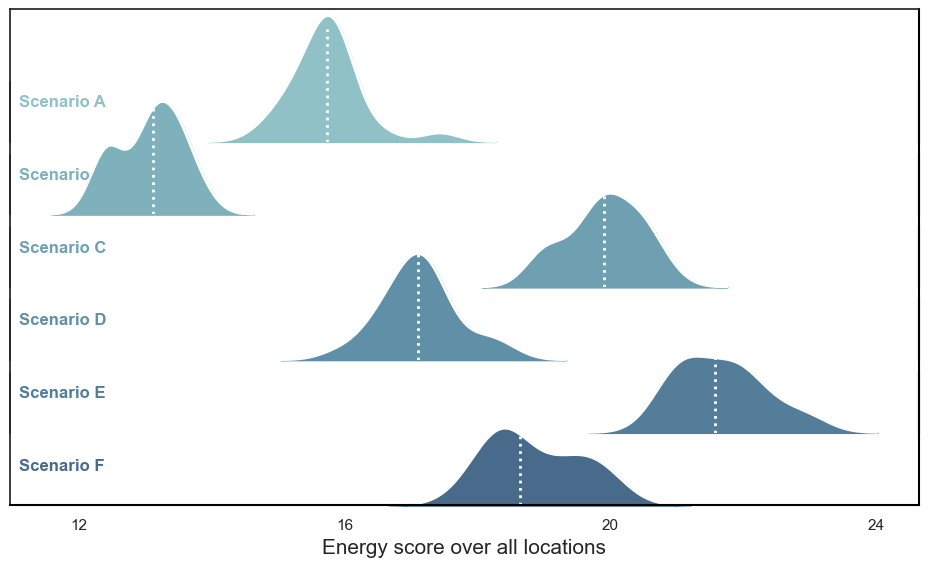

In [451]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

#energyscores_locations = pd.read_csv('../fludat/multitarget_loc_MOBS.csv')
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(energyscores_locations, row="Label", hue="Label", aspect=10, height=1, palette=pal)


#for ax in g.axes.flat:
    
    # Plot a vertical line at x=20 for each subplot
   # ax.axvline(20,ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
 #   ax.axvline(22,ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
  #  ax.axvline(24,ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
   # ax.axvline(26, ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
    #ax.axvline(28, ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)




# Draw the densities in a few steps
g.map(sns.kdeplot, "energyscore",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "energyscore", clip_on=False, color="w", lw=2, bw_adjust=1)

# passing color=None to refline() uses the hue mapping
#g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(.01, .3, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "energyscore")

# Define a function to plot the median
def plot_median(data, color, label):
    median = np.median(data['energyscore'])
    plt.axvline(median,ymin=0, ymax=.85, color='white', linestyle=':', linewidth=2)
    print(median)
    

# Apply the function to plot the median
g.map_dataframe(plot_median)


# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xticks=[12,16,20,24])
g.set_xticklabels([12,16,20,24])
#g.despine(bottom=True, left=True)


g.despine(bottom=True, left=False)
# Add a box around the full figure
#g.fig.patch.set_edgecolor('black')  # Set the edge color to black
#g.fig.patch.set_linewidth(2)        # Set the line width of the box

i=0

#g.set(xlim=[19, 29])

for ax in g.axes.flat:
    if i==0:
        ax.spines['top'].set_visible(True)
   # elif i==1:
      #  ax.set_xticks([20, 22, 24, 26, 28])  # Set custom tick locations
      #  ax.set_xticklabels([20, 22, 24, 26, 28], fontsize=13)  # Set custom tick labels and fontsize

    ax.spines['right'].set_visible(True)
    ax.spines['right'].set_edgecolor('black')
    ax.spines['right'].set_linewidth(1.5)
    
    if i==5:
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_edgecolor('black')
        ax.spines['bottom'].set_linewidth(1.5)


    i+=1

#plt.xlim([-45, 32])
plt.xlabel('Energy score over all locations', fontsize=15)

#plt.xticks([20,22,24,26,28],fontsize=13)

#plt.xticks([20,22,24,26,28])

#g.set_xticks([20, 22, 24, 26, 28])  # Set custom tick locations
#g.set_xticklabels([20, 22, 24, 26, 28], fontsize=13)  # Set custom tick labels and fontsize
#g.set(xticks=[20,22,24,26,28])

#plt.ylabel('% infectious-detectable \n stopped '+r'from traveling, $\phi_b$', y=1.1, fontsize=12)

#plt.savefig('../figs/multitarget_MOBS_kdeplot_1015.pdf')
plt.show()

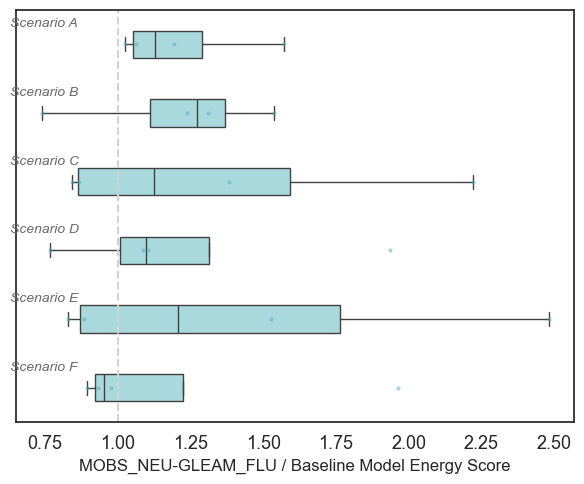

In [452]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
#plt.subplots_adjust(hspace=4)
i=1

baseline = pd.read_pickle('../fludat/flu-baseline_energyscore.pkl').rename(columns={'energyscore':'energyscore_baseline',
                                                                           'Model':'baseline_model'})

energyscoresdf = pd.read_pickle("../fludat/energyscore_individual_rd4_hosp_521.pkl")
energyscoresdf['target'] = 'inc hosp'

# calculate energy score ratio
ES_ratiodf = energyscoresdf.merge(baseline, on = ['location', 'target'])
ES_ratiodf['ES_ratio'] = ES_ratiodf['energyscore'] / ES_ratiodf['energyscore_baseline']    
rankinfo = ES_ratiodf[(ES_ratiodf.Model == 'MOBS_NEU-GLEAM_FLU')& (ES_ratiodf.location.isin(['02', '10','15','33','49']))]


my_order = rankinfo.Label.unique()

g = sns.boxplot(x='ES_ratio', y='Label', data=rankinfo,order=my_order, color = '#17B1BF', width=0.4,
               showfliers=False)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .4))
    
# plot underlying distribution
sns.swarmplot(x='ES_ratio', y='Label', data=rankinfo,order=my_order,color = "#49AFB7",alpha = .5,size=3,
              orient="h")  

g.set(yticklabels=[])
g.set(yticks=[])

plt.ylabel('', fontsize=15)
plt.xlabel('MOBS_NEU-GLEAM_FLU / Baseline Model Energy Score', fontsize=12)

i+=1 
#plt.title(scenario, fontsize=14)
#plt.xlim([0, 13])






plt.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'lightgray', alpha=1)


a = 0
for mod in list(my_order):
    plt.text(0.63,a-.25, mod, fontsize=10, style='italic', color='dimgray')
    a+=1

plt.xticks(fontsize=13)
plt.tight_layout()

#plt.savefig('../figs/ESratio_MOBS_1017.pdf')
plt.show()

# Found problem

In [585]:
# test number of states?
dfmobs = predictionsall[(predictionsall.Model=='MOBS_NEU-GLEAM_FLU') & (predictionsall.target=='inc hosp')]
#dfmobs = dfmobs[dfmobs.location.isin(['US','37','06'])]

#hospitalizations
target = 'hospitalization'
incidence=True
hosp = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target}.pq")
hosp['date'] = pd.to_datetime(hosp['date'])
hosp = hosp[(hosp.date>pd.to_datetime('2023-11-18'))&\
            (hosp.date<pd.to_datetime('2024-01-01'))].sort_values(by=['date']).reset_index().drop(columns=\
                                                                        ['Unnamed: 0', 'index','weekly_rate'])

hosp = hosp[(hosp.location != '72') &(hosp.location!='66')]
#h = np.array(hosp['value'])
#obs = np.array([h,d])

In [569]:
######### OLD #############

energyscores_locations = pd.DataFrame()
obs = np.array([np.array(hosp[hosp.location == i].value) for \
                     i in dfmobs.location.unique()])
for it in range(5):
    print(it)
    for model in ['MOBS_NEU-GLEAM_FLU']:
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:

            loc_array ={}
            j=0
            for loc in dfmobs.location.unique():
                if loc in ['72', '66']:
                    continue
                predictionshosp = dfmobs[(dfmobs.scenario_id == scenario + '-2023-08-14') & \
                                            (dfmobs.target_end_date <= hosp.date.max()) & \
                                            (dfmobs.target_end_date >= hosp.date.min())&\
                                            (dfmobs.Model == model) &\
                                            (dfmobs.location==loc)]

                newid = random.sample(list(predictionshosp['trajectory_id'].unique()), 
                                      k=len(list(predictionshosp['trajectory_id'].unique())))
                predictionshosp['new_id'] = predictionshosp['trajectory_id'].apply(lambda key: newid[key-1])

                Xhosp = np.array([np.array(predictionshosp[predictionshosp.new_id == i].value) for \
                         i in predictionshosp.new_id.unique()])
                
                loc_array[loc] = Xhosp
                
                j+=1
                
            A = []
            for i in range(len(Xhosp)):
                B = []
                for loc in dfmobs.location.unique():
                    if loc in ['72', '66']:
                        continue
                    B.append(loc_array[loc][i])
                B = np.array(B)
                A.append(B)

            A = np.array(A)
            
            print(A)


            ES = energyscore_multipletargets(A,obs)


            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':'US',  
                                 'energyscore': ES, 'it':it}, index=[0])

            energyscores_locations = pd.concat([energyscores_locations, newrow])

energyscores_locations = energyscores_locations.reset_index().drop(columns=['index'])  

0
[[[1.1200900e+02 1.2177600e+02 1.4615900e+02 1.7142900e+02 2.3380900e+02
   1.7822600e+02]
  [5.8201000e+01 6.6072000e+01 1.0090100e+02 1.6888700e+02 2.2795600e+02
   2.9586600e+02]
  [1.4303700e+03 1.5220840e+03 1.8728790e+03 1.8283980e+03 3.1332470e+03
   2.0766880e+03]]

 [[4.8612000e+01 1.7133200e+02 1.5534500e+02 1.0687600e+02 1.8445300e+02
   1.0249300e+02]
  [9.0000000e+00 2.8099000e+01 6.0536000e+01 8.9204000e+01 1.0532200e+02
   1.2637000e+02]
  [2.7657350e+03 3.6280590e+03 4.6773170e+03 6.4792440e+03 9.3118450e+03
   1.1368654e+04]]

 [[1.3191100e+02 2.3392800e+02 2.3077600e+02 3.6192100e+02 4.5501900e+02
   4.3534600e+02]
  [2.2922000e+01 5.3038000e+01 6.2436000e+01 7.1929000e+01 9.6490000e+01
   9.5075000e+01]
  [5.3300000e+02 1.5192220e+03 1.9020340e+03 1.8215800e+03 3.4947610e+03
   2.7377440e+03]]

 ...

 [[6.0000000e+01 2.7614000e+01 2.3352100e+02 2.7099900e+02 4.0732700e+02
   4.4557500e+02]
  [3.9941000e+01 4.3974000e+01 3.0383000e+01 2.3095000e+01 2.1176000e+01
   

[[[1.1200900e+02 1.2177600e+02 1.4615900e+02 1.7142900e+02 2.3380900e+02
   1.7822600e+02]
  [5.8201000e+01 6.6072000e+01 1.0090100e+02 1.6888700e+02 2.2795600e+02
   2.9586600e+02]
  [1.4303700e+03 1.5220840e+03 1.8728790e+03 1.8283980e+03 3.1332470e+03
   2.0766880e+03]]

 [[4.8612000e+01 1.7133200e+02 1.5534500e+02 1.0687600e+02 1.8445300e+02
   1.0249300e+02]
  [9.0000000e+00 2.8099000e+01 6.0536000e+01 8.9204000e+01 1.0532200e+02
   1.2637000e+02]
  [2.7657350e+03 3.6280590e+03 4.6773170e+03 6.4792440e+03 9.3118450e+03
   1.1368654e+04]]

 [[1.3191100e+02 2.3392800e+02 2.3077600e+02 3.6192100e+02 4.5501900e+02
   4.3534600e+02]
  [2.2922000e+01 5.3038000e+01 6.2436000e+01 7.1929000e+01 9.6490000e+01
   9.5075000e+01]
  [5.3300000e+02 1.5192220e+03 1.9020340e+03 1.8215800e+03 3.4947610e+03
   2.7377440e+03]]

 ...

 [[6.0000000e+01 2.7614000e+01 2.3352100e+02 2.7099900e+02 4.0732700e+02
   4.4557500e+02]
  [3.9941000e+01 4.3974000e+01 3.0383000e+01 2.3095000e+01 2.1176000e+01
   1.

[[[1.1200900e+02 1.2177600e+02 1.4615900e+02 1.7142900e+02 2.3380900e+02
   1.7822600e+02]
  [5.8201000e+01 6.6072000e+01 1.0090100e+02 1.6888700e+02 2.2795600e+02
   2.9586600e+02]
  [1.4303700e+03 1.5220840e+03 1.8728790e+03 1.8283980e+03 3.1332470e+03
   2.0766880e+03]]

 [[4.8612000e+01 1.7133200e+02 1.5534500e+02 1.0687600e+02 1.8445300e+02
   1.0249300e+02]
  [9.0000000e+00 2.8099000e+01 6.0536000e+01 8.9204000e+01 1.0532200e+02
   1.2637000e+02]
  [2.7657350e+03 3.6280590e+03 4.6773170e+03 6.4792440e+03 9.3118450e+03
   1.1368654e+04]]

 [[1.3191100e+02 2.3392800e+02 2.3077600e+02 3.6192100e+02 4.5501900e+02
   4.3534600e+02]
  [2.2922000e+01 5.3038000e+01 6.2436000e+01 7.1929000e+01 9.6490000e+01
   9.5075000e+01]
  [5.3300000e+02 1.5192220e+03 1.9020340e+03 1.8215800e+03 3.4947610e+03
   2.7377440e+03]]

 ...

 [[6.0000000e+01 2.7614000e+01 2.3352100e+02 2.7099900e+02 4.0732700e+02
   4.4557500e+02]
  [3.9941000e+01 4.3974000e+01 3.0383000e+01 2.3095000e+01 2.1176000e+01
   1.

[[[1.1200900e+02 1.2177600e+02 1.4615900e+02 1.7142900e+02 2.3380900e+02
   1.7822600e+02]
  [5.8201000e+01 6.6072000e+01 1.0090100e+02 1.6888700e+02 2.2795600e+02
   2.9586600e+02]
  [1.4303700e+03 1.5220840e+03 1.8728790e+03 1.8283980e+03 3.1332470e+03
   2.0766880e+03]]

 [[4.8612000e+01 1.7133200e+02 1.5534500e+02 1.0687600e+02 1.8445300e+02
   1.0249300e+02]
  [9.0000000e+00 2.8099000e+01 6.0536000e+01 8.9204000e+01 1.0532200e+02
   1.2637000e+02]
  [2.7657350e+03 3.6280590e+03 4.6773170e+03 6.4792440e+03 9.3118450e+03
   1.1368654e+04]]

 [[1.3191100e+02 2.3392800e+02 2.3077600e+02 3.6192100e+02 4.5501900e+02
   4.3534600e+02]
  [2.2922000e+01 5.3038000e+01 6.2436000e+01 7.1929000e+01 9.6490000e+01
   9.5075000e+01]
  [5.3300000e+02 1.5192220e+03 1.9020340e+03 1.8215800e+03 3.4947610e+03
   2.7377440e+03]]

 ...

 [[6.0000000e+01 2.7614000e+01 2.3352100e+02 2.7099900e+02 4.0732700e+02
   4.4557500e+02]
  [3.9941000e+01 4.3974000e+01 3.0383000e+01 2.3095000e+01 2.1176000e+01
   1.

[[[1.1200900e+02 1.2177600e+02 1.4615900e+02 1.7142900e+02 2.3380900e+02
   1.7822600e+02]
  [5.8201000e+01 6.6072000e+01 1.0090100e+02 1.6888700e+02 2.2795600e+02
   2.9586600e+02]
  [1.4303700e+03 1.5220840e+03 1.8728790e+03 1.8283980e+03 3.1332470e+03
   2.0766880e+03]]

 [[4.8612000e+01 1.7133200e+02 1.5534500e+02 1.0687600e+02 1.8445300e+02
   1.0249300e+02]
  [9.0000000e+00 2.8099000e+01 6.0536000e+01 8.9204000e+01 1.0532200e+02
   1.2637000e+02]
  [2.7657350e+03 3.6280590e+03 4.6773170e+03 6.4792440e+03 9.3118450e+03
   1.1368654e+04]]

 [[1.3191100e+02 2.3392800e+02 2.3077600e+02 3.6192100e+02 4.5501900e+02
   4.3534600e+02]
  [2.2922000e+01 5.3038000e+01 6.2436000e+01 7.1929000e+01 9.6490000e+01
   9.5075000e+01]
  [5.3300000e+02 1.5192220e+03 1.9020340e+03 1.8215800e+03 3.4947610e+03
   2.7377440e+03]]

 ...

 [[6.0000000e+01 2.7614000e+01 2.3352100e+02 2.7099900e+02 4.0732700e+02
   4.4557500e+02]
  [3.9941000e+01 4.3974000e+01 3.0383000e+01 2.3095000e+01 2.1176000e+01
   1.

In [590]:
energyscores_locations = pd.DataFrame()
obs = np.array([np.array(hosp[hosp.location == i].value) for \
                     i in dfmobs.location.unique()])
for it in range(100):
    print(it)
    for model in ['MOBS_NEU-GLEAM_FLU']:
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:

            loc_array ={}
            j=0
            
            dfall = pd.DataFrame()
            for loc in dfmobs.location.unique():
                if loc in ['72', '66']:
                    continue
                predictionshosp = dfmobs[(dfmobs.scenario_id == scenario + '-2023-08-14') & \
                                            (dfmobs.target_end_date <= hosp.date.max()) & \
                                            (dfmobs.target_end_date >= hosp.date.min())&\
                                            (dfmobs.Model == model) &\
                                            (dfmobs.location==loc)]

                newid = random.sample(list(predictionshosp['trajectory_id'].unique()), 
                                      k=len(list(predictionshosp['trajectory_id'].unique())))
                predictionshosp['new_id'] = predictionshosp['trajectory_id'].apply(lambda key: newid[key-1])

                dfall = pd.concat([dfall,predictionshosp])
                
            tlist = []
            for tid in dfall.new_id.unique():
                dfilt = dfall[dfall.new_id==tid]
                llist = []
                for loc in dfilt.location.unique():
                    d = dfilt[dfilt.location==loc].sort_values(by='target_end_date')
                    llist.append(list(d.value))
                    
                tlist.append(llist)
                

            A = np.array(tlist)
            
            #print(A)


            ES = energyscore_multipletargets(A,obs)


            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':'US',  
                                 'energyscore': ES, 'it':it}, index=[0])

            energyscores_locations = pd.concat([energyscores_locations, newrow])

energyscores_locations = energyscores_locations.reset_index().drop(columns=['index'])  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [594]:
energyscores_locations[energyscores_locations.Label=='Scenario A']

,Model,Label,location,energyscore,it
0,MOBS_NEU-GLEAM_FLU,Scenario A,US,9.553632,0
6,MOBS_NEU-GLEAM_FLU,Scenario A,US,9.569049,1
12,MOBS_NEU-GLEAM_FLU,Scenario A,US,9.568480,2
18,MOBS_NEU-GLEAM_FLU,Scenario A,US,9.565857,3
24,MOBS_NEU-GLEAM_FLU,Scenario A,US,9.565884,4
...,...,...,...,...,...
570,MOBS_NEU-GLEAM_FLU,Scenario A,US,9.554076,95
576,MOBS_NEU-GLEAM_FLU,Scenario A,US,9.565395,96
582,MOBS_NEU-GLEAM_FLU,Scenario A,US,9.558681,97
588,MOBS_NEU-GLEAM_FLU,Scenario A,US,9.566414,98


9.563423675146002
14.035708367463187
8.915382391483575
16.39234248509506
8.980806988952526
18.73807522201532


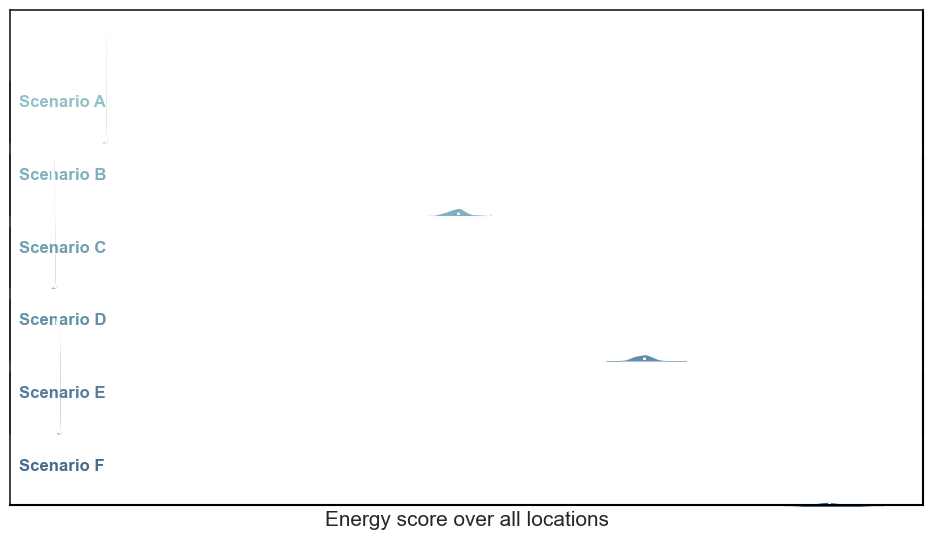

In [591]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

#energyscores_locations = pd.read_csv('../fludat/multitarget_loc_MOBS.csv')
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(energyscores_locations, row="Label", hue="Label", aspect=10, height=1, palette=pal)


#for ax in g.axes.flat:
    
    # Plot a vertical line at x=20 for each subplot
   # ax.axvline(20,ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
 #   ax.axvline(22,ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
  #  ax.axvline(24,ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
   # ax.axvline(26, ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)
    #ax.axvline(28, ymin=0, ymax=1, color='gray', linestyle='-', linewidth=1)




# Draw the densities in a few steps
g.map(sns.kdeplot, "energyscore",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "energyscore", clip_on=False, color="w", lw=2, bw_adjust=1)

# passing color=None to refline() uses the hue mapping
#g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(.01, .3, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "energyscore")

# Define a function to plot the median
def plot_median(data, color, label):
    median = np.median(data['energyscore'])
    plt.axvline(median,ymin=0, ymax=.85, color='white', linestyle=':', linewidth=2)
    print(median)
    

# Apply the function to plot the median
g.map_dataframe(plot_median)


# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xticks=[])
#g.set_xticklabels([26,28,30,32,34,36])
#g.despine(bottom=True, left=True)


g.despine(bottom=True, left=False)
# Add a box around the full figure
#g.fig.patch.set_edgecolor('black')  # Set the edge color to black
#g.fig.patch.set_linewidth(2)        # Set the line width of the box

i=0

#g.set(xlim=[19, 29])

for ax in g.axes.flat:
    if i==0:
        ax.spines['top'].set_visible(True)
   # elif i==1:
      #  ax.set_xticks([20, 22, 24, 26, 28])  # Set custom tick locations
      #  ax.set_xticklabels([20, 22, 24, 26, 28], fontsize=13)  # Set custom tick labels and fontsize

    ax.spines['right'].set_visible(True)
    ax.spines['right'].set_edgecolor('black')
    ax.spines['right'].set_linewidth(1.5)
    
    if i==5:
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_edgecolor('black')
        ax.spines['bottom'].set_linewidth(1.5)


    i+=1

#plt.xlim([-45, 32])
plt.xlabel('Energy score over all locations', fontsize=15)

#plt.xticks([20,22,24,26,28],fontsize=13)

#plt.xticks([20,22,24,26,28])

#g.set_xticks([20, 22, 24, 26, 28])  # Set custom tick locations
#g.set_xticklabels([20, 22, 24, 26, 28], fontsize=13)  # Set custom tick labels and fontsize
#g.set(xticks=[20,22,24,26,28])

#plt.ylabel('% infectious-detectable \n stopped '+r'from traveling, $\phi_b$', y=1.1, fontsize=12)

#plt.savefig('../figs/multitarget_MOBS_kdeplot_1015.pdf')
plt.show()

<Axes: xlabel='energyscore', ylabel='Label'>

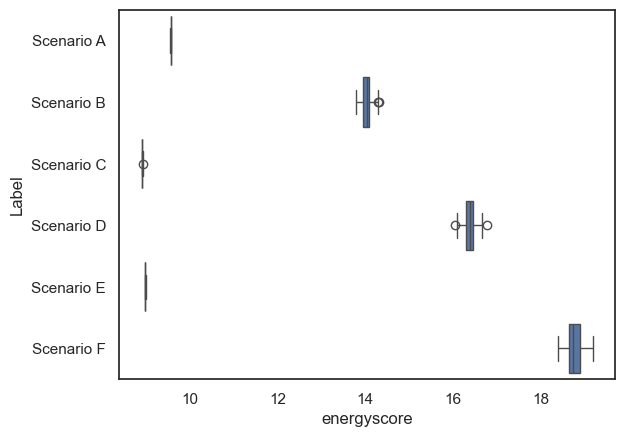

In [592]:
sns.boxplot(x='energyscore',y='Label',data=energyscores_locations)

In [546]:
predictionshosp

,origin_date,scenario_id,target,horizon,location,age_group,output_type,output_type_id,value,Model,trajectory_id,target_end_date,new_id
381400,2023-09-03,F-2023-08-14,inc hosp,12.0,US,0-130,sample,1,2958.079,MOBS_NEU-GLEAM_FLU,1,2023-11-25,13
381401,2023-09-03,F-2023-08-14,inc hosp,12.0,US,0-130,sample,2,6221.384,MOBS_NEU-GLEAM_FLU,2,2023-11-25,78
381402,2023-09-03,F-2023-08-14,inc hosp,12.0,US,0-130,sample,3,837.241,MOBS_NEU-GLEAM_FLU,3,2023-11-25,43
381403,2023-09-03,F-2023-08-14,inc hosp,12.0,US,0-130,sample,4,3254.854,MOBS_NEU-GLEAM_FLU,4,2023-11-25,90
381404,2023-09-03,F-2023-08-14,inc hosp,12.0,US,0-130,sample,5,4029.107,MOBS_NEU-GLEAM_FLU,5,2023-11-25,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081095,2023-09-03,F-2023-08-14,inc hosp,34.0,US,0-130,sample,96,2084.178,MOBS_NEU-GLEAM_FLU,96,2024-04-27,12
1081096,2023-09-03,F-2023-08-14,inc hosp,34.0,US,0-130,sample,97,640.458,MOBS_NEU-GLEAM_FLU,97,2024-04-27,71
1081097,2023-09-03,F-2023-08-14,inc hosp,34.0,US,0-130,sample,98,1077.945,MOBS_NEU-GLEAM_FLU,98,2024-04-27,25
1081098,2023-09-03,F-2023-08-14,inc hosp,34.0,US,0-130,sample,99,701.266,MOBS_NEU-GLEAM_FLU,99,2024-04-27,92


In [582]:
energyscores_locations = pd.DataFrame()
obs = np.array([np.array(hosp[hosp.location == i].value) for \
                     i in dfmobs.location.unique()])
for it in range(5):
    print(it)
    for model in ['MOBS_NEU-GLEAM_FLU']:
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:

            loc_array ={}
            j=0
            
            dfall = pd.DataFrame()
            for loc in dfmobs.location.unique():
                if loc in ['72', '66']:
                    continue
                predictionshosp = dfmobs[(dfmobs.scenario_id == scenario + '-2023-08-14') & \
                                            (dfmobs.target_end_date <= hosp.date.max()) & \
                                            (dfmobs.target_end_date >= hosp.date.min())&\
                                            (dfmobs.Model == model) &\
                                            (dfmobs.location==loc)]

                newid = random.sample(list(predictionshosp['trajectory_id'].unique()), 
                                      k=len(list(predictionshosp['trajectory_id'].unique())))
                predictionshosp['new_id'] = predictionshosp['trajectory_id'].apply(lambda key: newid[key-1])

                dfall = pd.concat([dfall,predictionshosp])
                
            tlist = []
            for tid in dfall.new_id.unique():
                dfilt = dfall[dfall.new_id==tid]
                llist = []
                for loc in dfilt.location.unique():
                    d = dfilt[dfilt.location==loc].sort_values(by='target_end_date')
                    llist.append(list(d.value))
                    
                tlist.append(llist)
                

            A = np.array(tlist)
            
            #print(A)


            ES = energyscore_multipletargets(A,obs)


            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':'US',  
                                 'energyscore': ES, 'it':it}, index=[0])

            energyscores_locations = pd.concat([energyscores_locations, newrow])

energyscores_locations = energyscores_locations.reset_index().drop(columns=['index'])  

0
1
2
3
4
